# Avance 4. Modelos alternativos

## Proyecto Integrador - MNA

### Equipo 21

Integrantes del equipo:
- Guadalupe Esmeralda González Maldonado - A01795767
- Marco Daniel Cameros Bobadilla - A01795655
- Jesús Armando Anaya Orozco - A01795464

Nombre del dataset: DDR2019

## Introducción

Trabajamos con un dataset de imágenes de fondo de ojo etiquetadas en 5 niveles de severidad de retinopatía diabética (0 = sin DR, 1 = leve, 2 = moderada, 3 = severa, 4 = proliferativa). El problema es complicado, ya que hay mucho desbalance entre clases y las severidades adyacentes (1 vs 2, 3 vs 4) son clínicamente ambiguas.

En lugar de entrenar una red profunda de punta a punta lo cual exige mucho cómputo y datos, la idea es usar backbones preentrenados en ImageNet (DenseNet-121, EfficientNet-B1, EfficientNet-B4 y ConvNeXt-Tiny) como extractores de características. Cada imagen se convierte en un vector numérico (embedding) y un modelo de Machine Learning tabular (XGBoost, LightGBM o LinearSVC) clasifica a partir de esos vectores. Para lidiar con el desbalance y la ambigüedad, fusionamos las 5 clases originales en 3 (`0`, `1+2`, `3+4`), aplicamos augmentación de datos controlada y balanceamos el conjunto de entrenamiento.

La métrica principal es **macro-F1**, que pondera igual el rendimiento en cada clase y es más informativa que la exactitud cuando hay desbalance. También reportamos accuracy, matrices de confusión e importancia de características.

En total evaluamos 7 candidatos, cuatro variantes de XGBoost (una por backbone), dos de LightGBM (DenseNet-121 y EfficientNet-B4) y una de LinearSVC (EfficientNet-B1). El mejor se elige automáticamente por macro-F1 en validación.

Para que todo sea reproducible fijamos una semilla global y la búsqueda de hiperparámetros usa RandomizedSearchCV con `n_iter=12` y `cv=3`, lo que limita el cómputo a un máximo de 36 entrenamientos por candidato.

En el notebook, primero realizamos el setup y preprocesamiento (normalización ImageNet, CLAHE), luego balanceo y augmentación con el merge de 5 a 3, después extracción de embeddings, búsqueda de hiperparámetros para cada modelo y, para terminar, la comparación de los 7 candidatos con matrices de confusión, importancia de features y selección del mejor.

## 1) Setup del proyecto y dependencias

Aquí definimos entorno, rutas y librerías. Lo importante es que la ejecución sea consistente entre corridas para poder comparar resultados de forma justa.

Se agregan algunas instrucciones para ejecutar en el servidor de entrenamiento. Para entrenamiento local no son necesarias.

In [1]:
# !pip install -U pip
# !pip install deepspeed>=0.14.0 pydantic==2.0.0 pydantic_settings
# !pip install -U scikit-learn xgboost

Se agregaron los directorios locales para cargar los archivos en la máquina donde se ejecutó por última vez este notebook.

In [2]:
from pathlib import Path
import os
import random
import time
from collections import Counter

# Resolver la raíz del proyecto de forma robusta.
# Ruta local (ajustar según el entorno de ejecución).
PROJECT_ROOT = Path("/home/anaya/Development/Robomous/sam-ai")

# Ruta alternativa para ejecución en servidor Paperspace:
#PROJECT_ROOT = Path("/notebooks/sam-ai")

os.chdir(PROJECT_ROOT)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
import torch.nn as nn
from scipy.stats import randint, uniform
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.svm import LinearSVC

from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import ConvNeXt_Tiny_Weights, DenseNet121_Weights, EfficientNet_B1_Weights, EfficientNet_B4_Weights
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sam_ml.datasets import DDR2019Dataset
from sam_ml.preprocessing.filters import apply_clahe_bgr

In [4]:
# Fijar semillas para reproducibilidad.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = PROJECT_ROOT / "data" / "processed" / "ddr2019_380"
LABELS_CSV = DATA_DIR / "labels.csv"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR (baseline): {DATA_DIR}")
print(f"labels.csv existe: {LABELS_CSV.exists()}")


PROJECT_ROOT: /home/anaya/Development/Robomous/sam-ai
DATA_DIR (baseline): /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019_380
labels.csv existe: True


In [5]:
# Cargar dataset base (una imagen por muestra) y validar contrato de salida.
# Se confirma shape, rango y tipo de label para detectar problemas de carga tempranamente.
base_dataset_train = DDR2019Dataset(
    data_dir=DATA_DIR,
    split="train",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=transforms.ToTensor(),
    random_state=SEED,
)

base_dataset_all = DDR2019Dataset(
    data_dir=DATA_DIR,
    split="all",
    transform=transforms.ToTensor(),
    random_state=SEED,
)

image_sample, label_sample = base_dataset_train[0]

print(f"Muestras train: {len(base_dataset_train)}")
print(f"Muestras all: {len(base_dataset_all)}")
print(f"Shape imagen: {tuple(image_sample.shape)}")
print(f"Label de ejemplo: {label_sample}")


Muestras train: 9389
Muestras all: 12522
Shape imagen: (3, 380, 380)
Label de ejemplo: 0


### Verificación de carga del dataset

Cargamos dos instancias de `DDR2019Dataset`: una con `split="train"` (75 % de los datos, la que usaremos para balanceo, augmentación y extracción de features) y otra con `split="all"`, dataset completo, útil para inspección general.

`DATA_DIR` apunta a `ddr2019_380`, que contiene las imágenes redimensionadas a 380×380 píxeles y un archivo `labels.csv` con las 5 etiquetas originales (0–4). Lo que esperamos al cargar es un tensor RGB en `[0, 1]` con shape `(3, 380, 380)`.

Validamos shape y label como "sanity check" rápido. En este punto el dataset todavía tiene las 5 clases originales; la fusión a 3 se hace más adelante.

## 2) Configuración de preprocesamiento para el baseline

Para el baseline usamos la normalización que espera el modelo preentrenado. `DenseNet121_Weights.DEFAULT` provee los pesos y, a través de `weights.transforms()`, nos da los valores de `mean` y `std` por canal RGB que se usaron al entrenar en ImageNet.

Normalizar con estas estadísticas no mejora el contraste de la imagen, lo que hace es alinear la distribución de píxeles con la que el backbone espera, para que los features extraídos no se degraden. También mantenemos el tamaño de entrada original de la red para que el comportamiento sea estable.

In [6]:
# Obtener pesos preentrenados y sus estadísticas de normalización para el baseline.
densenet_weights = DenseNet121_Weights.DEFAULT
densenet_preset = densenet_weights.transforms()

# mean/std por canal RGB extraídos del preset de ImageNet.
densenet_norm_mean = torch.tensor(densenet_preset.mean, dtype=torch.float32)
densenet_norm_std = torch.tensor(densenet_preset.std, dtype=torch.float32)

print("Normalización del baseline (DenseNet-121):")
print(f"  input_size esperado: {densenet_preset.crop_size[0]} x {densenet_preset.crop_size[0]}")
print(f"  mean: {densenet_norm_mean.tolist()}")
print(f"  std: {densenet_norm_std.tolist()}")


Normalización del baseline (DenseNet-121):
  input_size esperado: 224 x 224
  mean: [0.48500001430511475, 0.4560000002384186, 0.4059999883174896]
  std: [0.2290000021457672, 0.2240000069141388, 0.22499999403953552]


## 3) Transformaciones de normalización del baseline

Aquí definimos las funciones que preparan cada imagen para que el backbone la "vea" en condiciones similares a su preentrenamiento.

Las tres funciones son `normalize_with_stats_torch` (normalización canal a canal), `denormalize_with_stats_torch` (para poder visualizar imágenes de vuelta) y `preprocess_image_for_densenet` (pipeline completo de preprocesamiento para el baseline).

In [7]:
def normalize_with_stats_torch(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Normalizar tensor RGB canal a canal con media y desviación estándar.

    Parámetros
    ----------
    x : torch.Tensor — imagen con shape (3, H, W) en [0, 1].
    mean, std : torch.Tensor — estadísticas por canal (shape (3,)).

    Retorna
    -------
    torch.Tensor normalizado con la misma shape.
    """
    m = mean.view(3, 1, 1).to(x.device, x.dtype)
    s = std.view(3, 1, 1).to(x.device, x.dtype).clamp_min(1e-8)
    return (x - m) / s


def denormalize_with_stats_torch(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Revertir la normalización para recuperar valores en [0, 1] (útil para visualización).

    Parámetros
    ----------
    x : torch.Tensor — imagen normalizada (3, H, W).
    mean, std : torch.Tensor — las mismas estadísticas usadas en la normalización.
    """
    m = mean.view(3, 1, 1).to(x.device, x.dtype)
    s = std.view(3, 1, 1).to(x.device, x.dtype)
    return x * s + m


def preprocess_image_for_densenet(x: torch.Tensor) -> torch.Tensor:
    """Pipeline completo de preprocesamiento para el baseline DenseNet-121.

    Clampea a [0, 1] y normaliza con las estadísticas de ImageNet del preset.
    """
    x = x.float().clamp(0.0, 1.0)
    return normalize_with_stats_torch(x, densenet_norm_mean, densenet_norm_std)


In [8]:
def compute_eval_metrics(y_true, y_pred) -> dict:
    """Calcular métricas de evaluación: accuracy, precision, recall y F1 (macro).

    Parámetros
    ----------
    y_true : array-like — etiquetas reales.
    y_pred : array-like — predicciones del modelo.

    Retorna
    -------
    dict con val_accuracy, val_precision_macro, val_recall_macro y val_f1_macro.
    """
    return {
        "val_accuracy": float(accuracy_score(y_true, y_pred)),
        "val_precision_macro": float(precision_score(y_true, y_pred, average="macro", zero_division=0)),
        "val_recall_macro": float(recall_score(y_true, y_pred, average="macro", zero_division=0)),
        "val_f1_macro": float(f1_score(y_true, y_pred, average="macro", zero_division=0)),
    }

## 4) Balanceo de clases

En retinopatía diabética hay un desbalance importante entre clases, y eso impacta directamente la calidad del aprendizaje. Si se entrena sin control, el modelo tiende a optimizar para las clases frecuentes y degrada el recall en las menos representadas.

Lo que hacemos aquí es: primero fusionamos 5 clases en 3 (`0`, `1+2`, `3+4`) para reducir ambigüedad entre severidades adyacentes, luego construimos un set de entrenamiento balanceado real usando augmentación controlada (original + hflip + vflip + rotación) solo para la nueva clase 2, la cual tiene muy pocos ejemplos en comparación con las otras dos.

Lo manejamos así porque evitamos sesgo de frecuencia, es decir, que una clase domine la función objetivo, y evitamos sobre-augmentación sin criterio (que puede volver a desbalancear) y mantenemos el cómputo factible con los 4 modos de augmentación disponibles.

Esto conecta directamente con la elección de macro-F1 y macro-recall como métricas prioritarias. En escenarios desbalanceados, la accuracy puede verse alta y aun así ocultar mal desempeño en clases menos frecuentes. Balancear mejora cobertura por clase y estabilidad del entrenamiento, aunque incrementa el costo de cómputo por el número de muestras transformadas.

In [9]:
train_rows = base_dataset_train._rows.reset_index(drop=True).copy()

class_counts = train_rows["label"].value_counts().sort_index()
mean_count = class_counts.mean()
minority_threshold = mean_count * 0.5
minority_classes = set(class_counts[class_counts < minority_threshold].index.tolist())

AUGMENTATION_MULTIPLIER = 4
MAJORITY_CAP = 3500

augmentation_targets: dict[int, dict[str, float]] = {}
for label, count in class_counts.items():
    is_minority = int(label) in minority_classes
    target_count = int(count) * AUGMENTATION_MULTIPLIER if is_minority else int(count)
    augmentation_targets[int(label)] = {
        "current_count": int(count),
        "target_count": int(target_count),
        "multiplier": AUGMENTATION_MULTIPLIER if is_minority else 1,
        "is_minority": is_minority,
    }

downsampling_ratios: dict[int, dict[str, float]] = {}
for label, count in class_counts.items():
    is_majority = float(count) > float(mean_count)
    if is_majority and int(count) > MAJORITY_CAP:
        new_count = MAJORITY_CAP
        reduction_pct = (1.0 - (new_count / int(count))) * 100.0
    else:
        new_count = int(count)
        reduction_pct = 0.0
    downsampling_ratios[int(label)] = {
        "current_count": int(count),
        "new_count": int(new_count),
        "reduction_pct": float(reduction_pct),
        "is_downsampled": bool(is_majority and int(count) > MAJORITY_CAP),
    }

final_counts: dict[int, int] = {}
for label in sorted(class_counts.index.tolist()):
    if int(label) in minority_classes:
        final_counts[int(label)] = int(augmentation_targets[int(label)]["target_count"])
    else:
        final_counts[int(label)] = int(downsampling_ratios[int(label)]["new_count"])

original_imbalance_ratio = float(class_counts.max() / class_counts.min())
final_counts_series = pd.Series(final_counts).sort_index()
final_imbalance_ratio = float(final_counts_series.max() / final_counts_series.min())

print("Resumen de balanceo (baseline):")
print(f"  class_counts: {class_counts.to_dict()}")
print(f"  mean_count: {mean_count:.2f}")
print(f"  minority_threshold (50% mean): {minority_threshold:.2f}")
print(f"  minority_classes: {sorted(list(minority_classes))}")
print(f"  AUGMENTATION_MULTIPLIER: {AUGMENTATION_MULTIPLIER}")
print(f"  MAJORITY_CAP: {MAJORITY_CAP}")
print(f"  ratio original: {original_imbalance_ratio:.2f}:1")
print(f"  ratio final: {final_imbalance_ratio:.2f}:1")


Resumen de balanceo (baseline):
  class_counts: {0: 4699, 1: 472, 2: 3357, 3: 177, 4: 684}
  mean_count: 1877.80
  minority_threshold (50% mean): 938.90
  minority_classes: [1, 3, 4]
  AUGMENTATION_MULTIPLIER: 4
  MAJORITY_CAP: 3500
  ratio original: 26.55:1
  ratio final: 4.94:1


## 5) Utilidades de balanceo y augmentación

Estas utilidades concentran la lógica de muestreo por clase y de augmentación reproducible. La idea es mantener reglas consistentes para aumentar la exposición de clases minoritarias y reducir la dominancia de las mayoritarias.

`_sample_indices_per_class` selecciona índices aplicando downsampling a clases que superen `MAJORITY_CAP`, para que el entrenamiento no quede dominado por una sola clase. `_build_augmented_sample_list` construye la lista final de muestras como tuplas `(base_index, aug_id)`, donde `aug_id` indica la transformación (0 = original, 1 = hflip, 2 = vflip, 3 = rotación aleatoria); solo las clases minoritarias reciben las 4 variantes. `_draw_rotation_angles` genera ángulos reproducibles en [10°, 15°] con signo aleatorio.

Todo está controlado por `SEED` para reproducibilidad total. La augmentación solo se aplica en entrenamiento y las transformaciones son razonables para imágenes de fondo de ojo, donde la orientación no define la patología.

In [10]:
def _sample_indices_per_class(
    rows: pd.DataFrame,
    majority_cap: int,
    seed: int,
) -> list[int]:
    """Seleccionar índices de entrenamiento con downsampling en clases mayoritarias.

    Parámetros
    ----------
    rows : pd.DataFrame — filas del dataset con columna 'label'.
    majority_cap : int — máximo de muestras permitido por clase mayoritaria.
    seed : int — semilla para reproducibilidad del muestreo.

    Retorna
    -------
    list[int] — índices seleccionados (sin augmentación aún).
    """
    rng = np.random.default_rng(seed)
    selected: list[int] = []

    counts = rows["label"].value_counts().sort_index()
    mean_count_local = counts.mean()

    for label in sorted(counts.index.tolist()):
        cls_rows = rows[rows["label"] == label]
        cls_indices = cls_rows.index.to_numpy()
        is_majority = counts[label] > mean_count_local

        if is_majority and len(cls_indices) > majority_cap:
            chosen = rng.choice(cls_indices, size=majority_cap, replace=False)
            selected.extend(chosen.tolist())
        else:
            selected.extend(cls_indices.tolist())

    return selected


def _build_augmented_sample_list(
    rows: pd.DataFrame,
    selected_indices: list[int],
    minority_set: set[int],
) -> list[tuple[int, int]]:
    """Construir lista de muestras (base_index, aug_id) expandiendo clases minoritarias.

    Para cada índice seleccionado:
    - Si pertenece a una clase minoritaria → genera 4 tuplas (aug_id 0-3).
    - Si no → genera 1 tupla (aug_id 0, solo original).

    aug_id: 0=original, 1=hflip, 2=vflip, 3=rotación aleatoria.
    """
    samples: list[tuple[int, int]] = []
    for idx in selected_indices:
        label = int(rows.loc[idx, "label"])
        if label in minority_set:
            # 0 = original, 1 = hflip, 2 = vflip, 3 = rot
            for aug_id in (0, 1, 2, 3):
                samples.append((int(idx), int(aug_id)))
        else:
            samples.append((int(idx), 0))
    return samples


def _draw_rotation_angles(rng: np.random.Generator) -> tuple[float, float]:
    """Generar dos ángulos de rotación distintos con magnitud en [10°, 15°] y signo aleatorio."""

    def _one_angle() -> float:
        mag = float(rng.uniform(10.0, 15.0))
        sign = -1.0 if rng.random() < 0.5 else 1.0
        return sign * mag

    angle1 = _one_angle()
    angle2 = _one_angle()
    while abs(angle2 - angle1) < 1e-6:
        angle2 = _one_angle()
    return angle1, angle2



## 6) Verificación inicial del pipeline

Este bloque valida la integridad básica del flujo antes de entrenar. Formato y dimensiones de tensores, etiquetas en rango válido, consistencia entre tamaño del batch y contenido. Es una verificación rápida para detectar errores de datos temprano y evitar diagnósticos confusos durante el entrenamiento.

In [11]:
# Verificación rápida: cargar un mini-batch y comprobar shapes y rangos.
batch_size = 8
baseline_loader = DataLoader(
    base_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

images_batch, labels_batch = next(iter(baseline_loader))

print("Verificación rápida:")
print(f"  images_batch shape: {tuple(images_batch.shape)}")
print(f"  labels_batch shape: {tuple(labels_batch.shape)}")
print(f"  rango imágenes: [{float(images_batch.min()):.3f}, {float(images_batch.max()):.3f}]")


Verificación rápida:
  images_batch shape: (8, 3, 380, 380)
  labels_batch shape: (8,)
  rango imágenes: [0.000, 1.000]


=== Resumen de pipeline ===
DATA_DIR: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019_380
Split train base: 9389
Split all base: 12522
images_batch shape: (8, 3, 380, 380)
labels_batch shape: (8,)
Distribución original (train): {0: 4699, 1: 472, 2: 3357, 3: 177, 4: 684}
Distribución final objetivo: {0: 3500, 1: 1888, 2: 3357, 3: 708, 4: 2736}
Ratio original: 26.55:1
Ratio final: 4.94:1


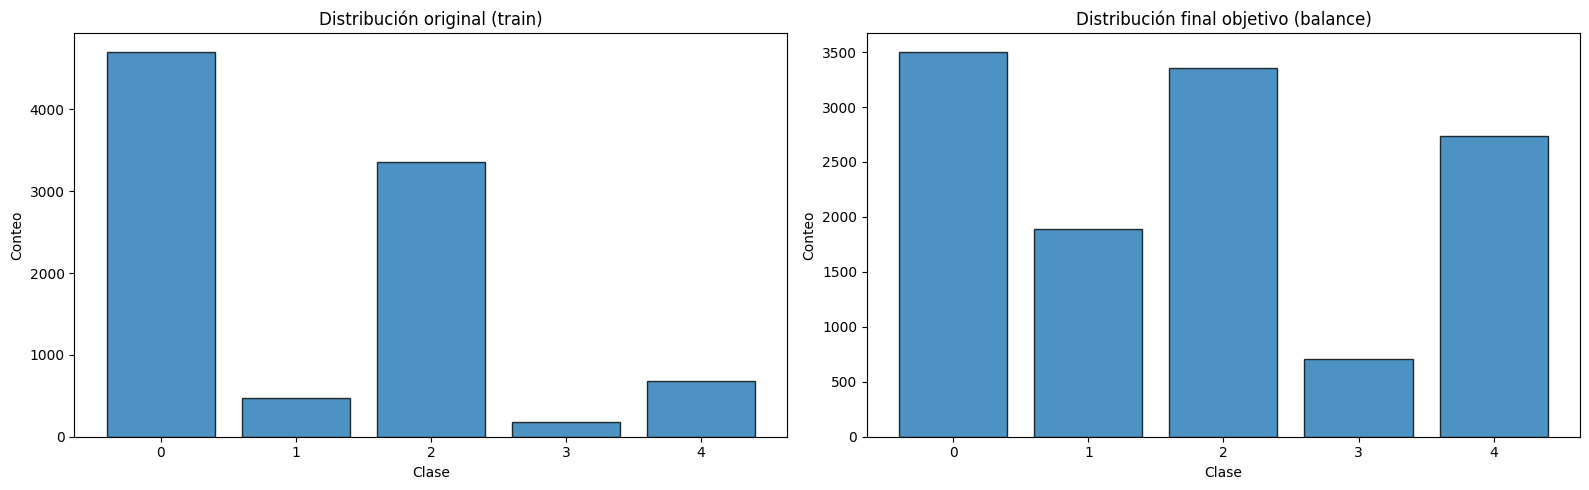

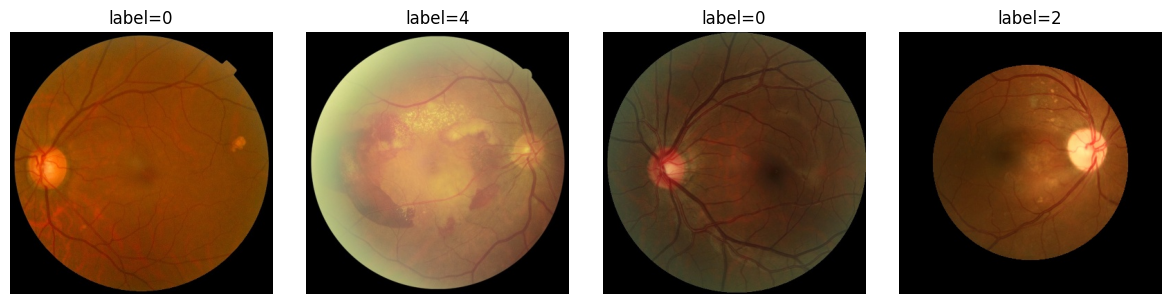

In [12]:
# Resumen consolidado: rutas, splits, distribuciones y visualización de muestras.
print("=== Resumen de pipeline ===")
print(f"DATA_DIR: {DATA_DIR}")
print(f"Split train base: {len(base_dataset_train)}")
print(f"Split all base: {len(base_dataset_all)}")
print(f"images_batch shape: {tuple(images_batch.shape)}")
print(f"labels_batch shape: {tuple(labels_batch.shape)}")
print(f"Distribución original (train): {class_counts.to_dict()}")
print(f"Distribución final objetivo: {final_counts_series.to_dict()}")
print(f"Ratio original: {original_imbalance_ratio:.2f}:1")
print(f"Ratio final: {final_imbalance_ratio:.2f}:1")

# Graficar distribución original vs final objetivo.
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

classes_sorted = sorted(class_counts.index.tolist())
x = np.arange(len(classes_sorted))
orig_values = [int(class_counts.loc[c]) for c in classes_sorted]
final_values = [int(final_counts_series.loc[c]) for c in classes_sorted]

axes[0].bar(x, orig_values, edgecolor="black", alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes_sorted)
axes[0].set_title("Distribución original (train)")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Conteo")

axes[1].bar(x, final_values, edgecolor="black", alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes_sorted)
axes[1].set_title("Distribución final objetivo (balance)")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("Conteo")

plt.tight_layout()
plt.show()

# Mostrar muestras del batch de la baseline.
n_show = min(4, images_batch.shape[0])
fig, axes = plt.subplots(1, n_show, figsize=(3 * n_show, 3))
if n_show == 1:
    axes = np.array([axes])

for i in range(n_show):
    image_vis = images_batch[i].detach().cpu().clamp(0.0, 1.0)
    axes[i].imshow(np.transpose(image_vis.numpy(), (1, 2, 0)))
    axes[i].set_title(f"label={int(labels_batch[i])}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Justificación de la fusión de 5 clases a 3 clases

Después de aplicar aumento de datos en las cinco clases originales, vimos que algunas categorías siguen muy desbalanceadas y que las fronteras entre severidades adyacentes (1 vs 2, 3 vs 4) son especialmente ruidosas. Intentamos entrenar respetando las 5 clases, pero los resultados no fueron buenos, el modelo confundía sistemáticamente los pares adyacentes.

Por eso decidimos fusionar clases 1 + 2 en una sola (retinopatía leve-moderada) y clases 3 + 4 en otra (retinopatía severa-proliferativa), manteniendo la clase 0 (sin retinopatía). Esto reduce la ambigüedad clínica entre grados que incluso los oftalmólogos confunden con frecuencia, aumenta las muestras por clase resultante y mantiene la distinción clínicamente relevante. Sin DR, DR no severa y DR severa.

Los resultados se reportan en el espacio de 3 clases, así que no son directamente comparables con benchmarks de 5 clases. El merge reduce granularidad, pero mejora estabilidad y confiabilidad de las predicciones.

## 7) Baseline (DenseNet-121 + XGBoost)

Usamos este baseline en la entrega anterior, porque es una forma práctica de clasificar imágenes con costo de cómputo controlado y resultados reproducibles. DenseNet-121 preentrenado convierte cada imagen en un vector de números que resume su contenido visual, y XGBoost toma ese vector y aprende a predecir la clase. Además es rápido de entrenar y permite revisar qué señales influyen más.

### Embedding

Es el vector numérico que produce el backbone al procesar una imagen. Se toma la red preentrenada, se le quita la capa de clasificación final (el _head_) y se reemplaza por `nn.Identity()`. Al pasar una imagen, la salida es un vector (de 1024 dimensiones para DenseNet-121, por ejemplo) que codifica las características visuales aprendidas. Ese vector se usa como fila de una tabla, y sobre esa tabla el modelo tabular aprende a clasificar.

La ventaja es que el backbone ya sabe detectar patrones visuales complejos (bordes, texturas, formas) gracias a su preentrenamiento en ImageNet, y el modelo tabular solo necesita aprender la relación entre esos patrones y las clases de retinopatía.

### macro-F1

Calcula el F1-score de cada clase por separado y promedia sin ponderar por frecuencia. Todas las clases pesan igual, independientemente de cuántas muestras tengan. Es la métrica más adecuada cuando hay desbalance, porque evita que una clase mayoritaria "infle" el resultado global.

El modelo debe superar un punto de referencia trivial, predecir siempre la clase mayoritaria. Si no lo supera, probablemente el problema está en la señal de los datos o en el preprocesamiento.

### Ajuste metodológico previo al feature engineering

Antes de extraer características hacemos algunos ajustes para que el entrenamiento sea más estable e interpretable. Reducimos de 5 a 3 clases agrupando etiquetas cercanas (`0`, `1+2`, `3+4`) para disminuir la ambigüedad entre grados adyacentes. También buscamos un balance controlado entre clases, la clase 0 se limita a `MAJORITY_CAP` muestras, las clases 1 y 2 se expanden con augmentación geométrica (hflip, vflip, rotación) y se verifica la distribución final con `final_train_counts` y `final_train_proportions`.

La augmentación es geométrica simple, razonable para imágenes de retina donde la orientación no define la patología. Se aplica CLAHE de forma consistente en train y val para evitar cambios de distribución entre conjuntos.

La distribución que se muestra en esta sección corresponde al dataset final que entra al modelo, no a una etapa intermedia.

In [13]:
def _imagenet_stats_from_weights(weights_enum: object) -> tuple[list[float], list[float]]:
    weights = weights_enum.DEFAULT
    mean = list(weights.meta.get("mean", (0.485, 0.456, 0.406)))
    std = list(weights.meta.get("std", (0.229, 0.224, 0.225)))
    return mean, std


def _input_size_from_weights(weights_enum: object, default: int = 224) -> int:
    weights = weights_enum.DEFAULT
    crop_size = getattr(weights.transforms(), "crop_size", None)
    if crop_size is None:
        return int(default)

    if isinstance(crop_size, (tuple, list)):
        if len(crop_size) == 0:
            return int(default)
        return int(crop_size[0])

    return int(crop_size)


def _imagenet_stats_from_densenet() -> tuple[list[float], list[float]]:
    return _imagenet_stats_from_weights(DenseNet121_Weights)


def _imagenet_stats_from_efficientnet_b1() -> tuple[list[float], list[float]]:
    return _imagenet_stats_from_weights(EfficientNet_B1_Weights)


def _imagenet_stats_from_efficientnet_b4() -> tuple[list[float], list[float]]:
    return _imagenet_stats_from_weights(EfficientNet_B4_Weights)


def _imagenet_stats_from_convnext_tiny() -> tuple[list[float], list[float]]:
    return _imagenet_stats_from_weights(ConvNeXt_Tiny_Weights)


def _to_gray(x: torch.Tensor) -> torch.Tensor:
    """Convertir RGB a escala de grises (tensor CHW en [0,1])."""
    r, g, b = x[0], x[1], x[2]
    return (0.2989 * r + 0.5870 * g + 0.1140 * b).clamp(0.0, 1.0)


def _global_features(x: torch.Tensor, hist_bins: int = 16) -> torch.Tensor:
    """Calcular features globales: media/desviación por canal RGB + histograma en escala de grises.

    Se concatenan como vector auxiliar al embedding del backbone.
    """
    ch_mean = x.mean(dim=(1, 2))
    ch_std = x.std(dim=(1, 2), unbiased=False)

    gray = _to_gray(x)
    hist = torch.histc(gray, bins=int(hist_bins), min=0.0, max=1.0)
    hist = hist / (hist.sum().clamp_min(1.0))

    return torch.cat([ch_mean, ch_std, hist], dim=0).float()


def _apply_geometry(
    image: torch.Tensor,
    aug_id: int,
    idx: int,
    seed: int,
) -> torch.Tensor:
    """Aplicar augmentación geométrica simple, reproducible por índice y semilla.

    aug_id: 0=original, 1=hflip, 2=vflip, 3=rotación aleatoria [10°-15°].
    """
    if int(aug_id) == 0:
        return image
    if int(aug_id) == 1:
        return TF.hflip(image)
    if int(aug_id) == 2:
        return TF.vflip(image)

    rng = np.random.default_rng(int(seed) + int(idx))
    mag = float(rng.uniform(10.0, 15.0))
    sign = -1.0 if rng.random() < 0.5 else 1.0
    angle = sign * mag

    return TF.rotate(
        image,
        angle=float(angle),
        interpolation=InterpolationMode.BILINEAR,
        fill=0.0,
    )


LABEL_MAP_5_TO_3: dict[int, int] = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}


class MappedLabelDataset(Dataset):
    """Envolver un dataset base y remapear sus etiquetas preservando soporte de _rows."""

    def __init__(self, base_dataset: DDR2019Dataset, label_map: dict[int, int]) -> None:
        self.base_dataset = base_dataset
        self.label_map = dict(label_map)
        self._rows = self.base_dataset._rows.copy()
        self._rows["label"] = self._rows["label"].map(self.label_map).astype(int)

    def __len__(self) -> int:
        return len(self.base_dataset)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        image, label = self.base_dataset[int(idx)]
        return image, int(self.label_map[int(label)])


class ClahePILTransform:
    """Aplicar CLAHE en espacio BGR y devolver imagen PIL en RGB."""

    def __call__(self, image: Image.Image) -> Image.Image:
        rgb = np.asarray(image.convert("RGB"), dtype=np.uint8)
        bgr = np.ascontiguousarray(rgb[..., ::-1])
        bgr_clahe = apply_clahe_bgr(bgr)
        rgb_clahe = np.ascontiguousarray(bgr_clahe[..., ::-1])
        return Image.fromarray(rgb_clahe)


class BaselineSingleFeatureDataset(Dataset):
    """Dataset baseline: imagen preprocesada para el backbone + features globales auxiliares.

    Cada muestra devuelve un diccionario con:
    - 'image': tensor normalizado listo para el backbone.
    - 'extra': vector de features globales (estadísticas de canal + histograma).
    - 'label': etiqueta (ya mapeada si corresponde).
    """

    def __init__(
        self,
        base_dataset: "DDR2019Dataset",
        samples: list[tuple[int, int]],
        seed: int,
        image_size: int = 224,
        hist_bins: int = 16,
        mean: list[float] | None = None,
        std: list[float] | None = None,
    ) -> None:
        self.base_dataset = base_dataset
        self.samples = list(samples)
        self.seed = int(seed)
        self.image_size = int(image_size)
        self.hist_bins = int(hist_bins)

        densenet_mean, densenet_std = _imagenet_stats_from_densenet()
        self.mean = list(densenet_mean if mean is None else mean)
        self.std = list(densenet_std if std is None else std)

    def __len__(self) -> int:
        return len(self.samples)

    def _prep_for_backbone(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        x = TF.resize(
            x,
            [self.image_size, self.image_size],
            interpolation=InterpolationMode.BILINEAR,
            antialias=True,
        )
        x = x.float().clamp(0.0, 1.0)

        extra = _global_features(x, hist_bins=self.hist_bins)
        x_norm = TF.normalize(x, mean=self.mean, std=self.std)
        return x_norm, extra

    def __getitem__(self, item_idx: int) -> dict[str, torch.Tensor]:
        base_index, aug_id = self.samples[int(item_idx)]
        image, label = self.base_dataset[int(base_index)]
        image = image.float().clamp(0.0, 1.0)

        image_aug = _apply_geometry(
            image,
            aug_id=int(aug_id),
            idx=int(base_index),
            seed=self.seed,
        )

        image_in, extra = self._prep_for_backbone(image_aug)

        return {
            "image": image_in,
            "extra": extra,
            "label": torch.tensor(int(label), dtype=torch.long),
        }


# Constructores de backbones como extractores de características (sin head de clasificación).
def build_densenet121_feature_extractor() -> nn.Module:
    """Construir DenseNet-121 preentrenado como extractor de features: salida (B, 1024)."""
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Identity()

    for p in model.parameters():
        p.requires_grad = False

    return model


def build_efficientnet_b1_feature_extractor() -> nn.Module:
    """Construir EfficientNet-B1 preentrenado como extractor de features: salida (B, 1280)."""
    model = models.efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)
    model.classifier = nn.Identity()

    for p in model.parameters():
        p.requires_grad = False

    return model


def build_efficientnet_b4_feature_extractor() -> nn.Module:
    """Construir EfficientNet-B4 preentrenado como extractor de features: salida (B, 1792)."""
    model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
    model.classifier = nn.Identity()

    for p in model.parameters():
        p.requires_grad = False

    return model


def build_convnext_tiny_feature_extractor() -> nn.Module:
    """Construir ConvNeXt-Tiny preentrenado como extractor de features: salida (B, 768)."""
    model = models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    model.classifier[2] = nn.Identity()

    for p in model.parameters():
        p.requires_grad = False

    return model


def _forward_backbone_features(feature_model: nn.Module, image: torch.Tensor) -> torch.Tensor:
    out = feature_model(image)
    if isinstance(out, torch.Tensor):
        return out
    if isinstance(out, (tuple, list)):
        out0 = out[0]
        if not isinstance(out0, torch.Tensor):
            raise TypeError("Backbone output tuple/list does not contain tensor features.")
        return out0
    if isinstance(out, dict):
        for key in ("features", "logits", "out"):
            if key in out and isinstance(out[key], torch.Tensor):
                return out[key]
    raise TypeError(f"Unsupported backbone output type: {type(out)}")


@torch.no_grad()
def extract_backbone_features(
    feature_model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    desc: str,
) -> tuple[np.ndarray, np.ndarray]:
    """Extraer features concatenadas (embedding del backbone + features globales auxiliares).

    Recorre el DataLoader completo en modo evaluación, concatena todos los vectores
    y devuelve matrices numpy (X, y) listas para entrenar un modelo tabular.
    """
    feature_model = feature_model.to(device)
    feature_model.eval()

    feats: list[np.ndarray] = []
    labels: list[np.ndarray] = []

    for batch in tqdm(loader, desc=desc, total=len(loader)):
        image = batch["image"].to(device, non_blocking=True)
        extra = batch["extra"].to(device, non_blocking=True)
        y = batch["label"].detach().cpu().numpy()

        f = _forward_backbone_features(feature_model, image)
        f = torch.cat([f, extra], dim=1)

        feats.append(f.detach().cpu().numpy())
        labels.append(y)

    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labels, axis=0)

    print("Dimensión de la matriz de features:", X.shape)
    return X, y


In [14]:
# 1) Cargar dataset con CLAHE consistente en train y val.
# CLAHE mejora el contraste local, lo cual ayuda a resaltar estructuras retinales.
# Se aplica el mismo preprocesamiento a ambos splits para evitar cambios de distribución.
DATA_DIR_BASELINE = DATA_DIR

clahe_to_tensor = transforms.Compose([
    ClahePILTransform(),
    transforms.ToTensor(),
])

baseline_train_ds_raw = DDR2019Dataset(
    data_dir=DATA_DIR_BASELINE,
    split="train",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=clahe_to_tensor,
    random_state=SEED,
)
baseline_val_ds_raw = DDR2019Dataset(
    data_dir=DATA_DIR_BASELINE,
    split="val",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=clahe_to_tensor,
    random_state=SEED,
)

baseline_train_ds = MappedLabelDataset(baseline_train_ds_raw, LABEL_MAP_5_TO_3)
baseline_val_ds = MappedLabelDataset(baseline_val_ds_raw, LABEL_MAP_5_TO_3)

print("Dataset baseline - decisiones de datos")
print(f"  DATA_DIR_BASELINE: {DATA_DIR_BASELINE}")
print(f"  train samples: {len(baseline_train_ds)}")
print(f"  val samples  : {len(baseline_val_ds)}")
print(f"  mapeo de etiquetas usado (5→3): {LABEL_MAP_5_TO_3}")
print(f"  etiquetas presentes en train tras mapeo: {sorted(baseline_train_ds._rows['label'].unique().tolist())}")
print("  consistencia de preprocesamiento: CLAHE se aplica tanto a train como a val")

Dataset baseline - decisiones de datos
  DATA_DIR_BASELINE: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019_380
  train samples: 9389
  val samples  : 3133
  mapeo de etiquetas usado (5→3): {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}
  etiquetas presentes en train tras mapeo: [0, 1, 2]
  consistencia de preprocesamiento: CLAHE se aplica tanto a train como a val


In [15]:
# 2) Estrategia de muestreo tras el merge 5→3 clases.
# Política por clase en entrenamiento:
# - Clase 0: se mantiene tal cual (sin augmentación).
# - Clase 1: se mantiene, pero se barajan los ejemplos para variabilidad.
# - Clase 2: se aplica augmentación ×4 (original + 3 variantes geométricas).
# Validación: solo merge de etiquetas, sin augmentación.
train_rows_baseline = baseline_train_ds._rows.reset_index(drop=True).copy()
class_counts_baseline = train_rows_baseline["label"].value_counts().sort_index()

CLASS2_AUGMENTATION_MODES = [0, 1, 2, 3]
rng = np.random.default_rng(SEED)
train_samples: list[tuple[int, int]] = []

for class_id in sorted(int(x) for x in class_counts_baseline.index.tolist()):
    class_indices = train_rows_baseline[train_rows_baseline["label"] == class_id].index.to_numpy()

    # Barajar clase 1 explícitamente para romper cualquier orden implícito.
    # Barajar clase 1 para romper cualquier orden implícito del dataset.
    if class_id == 1:
        class_indices = rng.permutation(class_indices)

    if class_id == 2:
        # ×4 solo para la clase severa fusionada (nueva clase 2).
        for aug_id in CLASS2_AUGMENTATION_MODES:
            train_samples.extend((int(idx), int(aug_id)) for idx in class_indices.tolist())
    else:
        # Clases 0 y 1: solo la imagen original.
        train_samples.extend((int(idx), 0) for idx in class_indices.tolist())

# Distribución final que efectivamente usa el modelo para entrenar.
train_counts_after_aug = (
    pd.Series([int(train_rows_baseline.loc[int(idx), "label"]) for idx, _ in train_samples])
    .value_counts()
    .sort_index()
)
train_proportions_after_aug = (train_counts_after_aug / train_counts_after_aug.sum()).sort_index()

print("Resumen de augmentación del set de entrenamiento (estrategia aplicada):")
print(f"  merged class_counts (raw train split): {class_counts_baseline.to_dict()}")
print("  clase 0: solo original")
print("  clase 1: solo original + orden barajado")
print(f"  clase 2: ×4 con modos {CLASS2_AUGMENTATION_MODES}")
print(f"  final_train_counts used by model: {train_counts_after_aug.to_dict()}")
print(
    "  final_train_proportions used by model (%): "
    + str({int(k): round(float(v) * 100.0, 2) for k, v in train_proportions_after_aug.items()})
)

# Validación mantiene distribución natural (etiquetas fusionadas, sin augmentación).
val_samples = [(int(i), 0) for i in range(len(baseline_val_ds))]

# Verificaciones rápidas de integridad.
print("Verificaciones de integridad:")
print(f"  train_samples: {len(train_samples)}")
print(f"  val_samples  : {len(val_samples)}")
print(f"  labels in train rows: {sorted(class_counts_baseline.index.astype(int).tolist())}")

check_idx = int(train_rows_baseline[train_rows_baseline["label"] == 2].index[0])
img_base, _ = baseline_train_ds[check_idx]
img_rot = _apply_geometry(img_base, aug_id=3, idx=check_idx, seed=SEED)
print(f"  augmentation changed sample (class 2, rotation): {bool(not torch.allclose(img_base, img_rot))}")

Resumen de augmentación del set de entrenamiento (estrategia aplicada):
  merged class_counts (raw train split): {0: 4699, 1: 3829, 2: 861}
  clase 0: solo original
  clase 1: solo original + orden barajado
  clase 2: ×4 con modos [0, 1, 2, 3]
  final_train_counts used by model: {0: 4699, 1: 3829, 2: 3444}
  final_train_proportions used by model (%): {0: 39.25, 1: 31.98, 2: 28.77}
Verificaciones de integridad:
  train_samples: 11972
  val_samples  : 3133
  labels in train rows: [0, 1, 2]
  augmentation changed sample (class 2, rotation): True


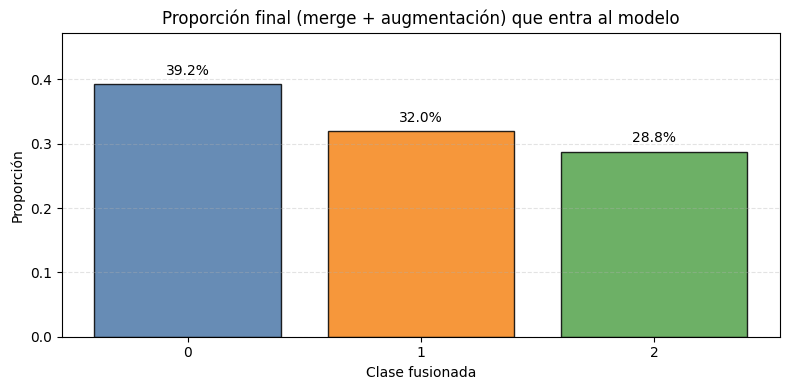

In [16]:
# Gráfica de la distribución proporcional final (después de merge + augmentación).
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(
    train_proportions_after_aug.index.astype(str),
    train_proportions_after_aug.values,
    color=["#4C78A8", "#F58518", "#54A24B"],
    edgecolor="black",
    alpha=0.85,
)

for bar, prop in zip(bars, train_proportions_after_aug.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{prop * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

ax.set_title("Proporción final (merge + augmentación) que entra al modelo")
ax.set_xlabel("Clase fusionada")
ax.set_ylabel("Proporción")
ax.set_ylim(0, min(1.0, float(train_proportions_after_aug.max()) + 0.08))
ax.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()

In [17]:
# Verificación: confirmar que train_samples y val_samples existen.
# La estrategia de muestreo/augmentación se define en la celda anterior;
# esta celda solo valida que están disponibles para las siguientes etapas.
if "train_samples" not in globals() or "val_samples" not in globals():
    raise RuntimeError(
        "No se encontraron train_samples/val_samples. Ejecuta primero la celda de estrategia de muestreo."
    )

print("Estrategia activa verificada: train_samples y val_samples ya están definidos.")
print(f"  train_samples: {len(train_samples)}")
print(f"  val_samples  : {len(val_samples)}")

Estrategia activa verificada: train_samples y val_samples ya están definidos.
  train_samples: 11972
  val_samples  : 3133


In [18]:
# 3) Extraer features con los 4 backbones: DenseNet121, EfficientNetB1, EfficientNetB4, ConvNeXtTiny.
FEATURE_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo para extracción de features: {FEATURE_DEVICE}")

if FEATURE_DEVICE.type == "cuda":
    # Precisión alta recomendada para GPUs con Tensor Cores (mejor throughput).
    torch.set_float32_matmul_precision("high")


def _make_loaders_for_backbone(
    image_size: int,
    mean: list[float],
    std: list[float],
    batch_size: int = 32,
) -> tuple[DataLoader, DataLoader]:
    train_fe_ds = BaselineSingleFeatureDataset(
        base_dataset=baseline_train_ds,
        samples=train_samples,
        seed=SEED,
        image_size=int(image_size),
        hist_bins=16,
        mean=mean,
        std=std,
    )
    val_fe_ds = BaselineSingleFeatureDataset(
        base_dataset=baseline_val_ds,
        samples=val_samples,
        seed=SEED,
        image_size=int(image_size),
        hist_bins=16,
        mean=mean,
        std=std,
    )

    num_workers = min(4, os.cpu_count() or 1)
    train_loader_local = DataLoader(
        train_fe_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    val_loader_local = DataLoader(
        val_fe_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=torch.cuda.is_available(),
    )
    return train_loader_local, val_loader_local


dense_mean, dense_std = _imagenet_stats_from_densenet()
effb1_mean, effb1_std = _imagenet_stats_from_efficientnet_b1()
effb4_mean, effb4_std = _imagenet_stats_from_efficientnet_b4()
convnext_tiny_mean, convnext_tiny_std = _imagenet_stats_from_convnext_tiny()
dense_image_size = 224
effb1_image_size = _input_size_from_weights(EfficientNet_B1_Weights, default=240)
effb4_image_size = _input_size_from_weights(EfficientNet_B4_Weights, default=380)
convnext_tiny_image_size = _input_size_from_weights(ConvNeXt_Tiny_Weights, default=224)

# Configuración de los 4 experimentos de extracción de features.
# Cada entrada define: backbone, tamaño de imagen esperado, y estadísticas de normalización.
# Al terminar, feature_sets contendrá {nombre: {X_train, y_train, X_val, y_val}} para cada backbone.
experiment_configs = [
    {
        "name": "DenseNet121",
        "model_builder": build_densenet121_feature_extractor,
        "mean": dense_mean,
        "std": dense_std,
        "image_size": dense_image_size,
        "extract_desc_train": "Extrayendo features (DenseNet121 train)",
        "extract_desc_val": "Extrayendo features (DenseNet121 val)",
    },
    {
        "name": "EfficientNetB1",
        "model_builder": build_efficientnet_b1_feature_extractor,
        "mean": effb1_mean,
        "std": effb1_std,
        "image_size": effb1_image_size,
        "extract_desc_train": "Extrayendo features (EfficientNetB1 train)",
        "extract_desc_val": "Extrayendo features (EfficientNetB1 val)",
    },
    {
        "name": "EfficientNetB4",
        "model_builder": build_efficientnet_b4_feature_extractor,
        "mean": effb4_mean,
        "std": effb4_std,
        "image_size": effb4_image_size,
        "extract_desc_train": "Extrayendo features (EfficientNetB4 train)",
        "extract_desc_val": "Extrayendo features (EfficientNetB4 val)",
    },
    {
        "name": "ConvNeXtTiny",
        "model_builder": build_convnext_tiny_feature_extractor,
        "mean": convnext_tiny_mean,
        "std": convnext_tiny_std,
        "image_size": convnext_tiny_image_size,
        "extract_desc_train": "Extrayendo features (ConvNeXtTiny train)",
        "extract_desc_val": "Extrayendo features (ConvNeXtTiny val)",
    },
]

feature_sets: dict[str, dict[str, np.ndarray]] = {}

for cfg in experiment_configs:
    print("\n" + "=" * 80)
    print(f"Extracción backbone: {cfg['name']}")
    print(f"  image_size: {cfg['image_size']}")
    print(f"  mean: {cfg['mean']}")
    print(f"  std : {cfg['std']}")

    train_loader_local, val_loader_local = _make_loaders_for_backbone(
        image_size=int(cfg["image_size"]),
        mean=list(cfg["mean"]),
        std=list(cfg["std"]),
    )

    feature_model = cfg["model_builder"]()
    X_train_local, y_train_local = extract_backbone_features(
        feature_model,
        train_loader_local,
        FEATURE_DEVICE,
        desc=str(cfg["extract_desc_train"]),
    )
    X_val_local, y_val_local = extract_backbone_features(
        feature_model,
        val_loader_local,
        FEATURE_DEVICE,
        desc=str(cfg["extract_desc_val"]),
    )

    print(f"  Labels train: {sorted(np.unique(y_train_local).tolist())}")
    print(f"  Labels val  : {sorted(np.unique(y_val_local).tolist())}")

    feature_sets[str(cfg["name"])] = {
        "X_train": X_train_local,
        "y_train": y_train_local,
        "X_val": X_val_local,
        "y_val": y_val_local,
    }

# Alias de compatibilidad: las celdas posteriores esperan X_train/y_train/X_val/y_val como DenseNet121.
X_train = feature_sets["DenseNet121"]["X_train"]
y_train = feature_sets["DenseNet121"]["y_train"]
X_val = feature_sets["DenseNet121"]["X_val"]
y_val = feature_sets["DenseNet121"]["y_val"]

Dispositivo para extracción de features: cuda

Extracción backbone: DenseNet121
  image_size: 224
  mean: [0.485, 0.456, 0.406]
  std : [0.229, 0.224, 0.225]


Extrayendo features (DenseNet121 train):   0%|          | 0/375 [00:00<?, ?it/s]

Dimensión de la matriz de features: (11972, 1046)


Extrayendo features (DenseNet121 val):   0%|          | 0/98 [00:00<?, ?it/s]

Dimensión de la matriz de features: (3133, 1046)
  Labels train: [0, 1, 2]
  Labels val  : [0, 1, 2]

Extracción backbone: EfficientNetB1
  image_size: 240
  mean: [0.485, 0.456, 0.406]
  std : [0.229, 0.224, 0.225]


Extrayendo features (EfficientNetB1 train):   0%|          | 0/375 [00:00<?, ?it/s]

Dimensión de la matriz de features: (11972, 1302)


Extrayendo features (EfficientNetB1 val):   0%|          | 0/98 [00:00<?, ?it/s]

Dimensión de la matriz de features: (3133, 1302)
  Labels train: [0, 1, 2]
  Labels val  : [0, 1, 2]

Extracción backbone: EfficientNetB4
  image_size: 380
  mean: [0.485, 0.456, 0.406]
  std : [0.229, 0.224, 0.225]


Extrayendo features (EfficientNetB4 train):   0%|          | 0/375 [00:00<?, ?it/s]

Dimensión de la matriz de features: (11972, 1814)


Extrayendo features (EfficientNetB4 val):   0%|          | 0/98 [00:00<?, ?it/s]

Dimensión de la matriz de features: (3133, 1814)
  Labels train: [0, 1, 2]
  Labels val  : [0, 1, 2]

Extracción backbone: ConvNeXtTiny
  image_size: 224
  mean: [0.485, 0.456, 0.406]
  std : [0.229, 0.224, 0.225]


Extrayendo features (ConvNeXtTiny train):   0%|          | 0/375 [00:00<?, ?it/s]

Dimensión de la matriz de features: (11972, 790)


Extrayendo features (ConvNeXtTiny val):   0%|          | 0/98 [00:00<?, ?it/s]

Dimensión de la matriz de features: (3133, 790)
  Labels train: [0, 1, 2]
  Labels val  : [0, 1, 2]


### Desempeño mínimo esperado (baseline ingenuo)

Un predictor ingenuo simplemente predice siempre la clase más frecuente del conjunto de entrenamiento, sin mirar la imagen. Es el piso absoluto de rendimiento, cualquier modelo que no lo supere no está aprendiendo nada útil.

El macro-F1 suele ser bajo con este predictor porque solo acierta en una clase y falla completamente en las demás. Al promediar F1 por clase sin ponderar, las clases con F1 = 0 arrastran el promedio. Todos los 7 candidatos deben superar estas cifras para ser considerados válidos.

In [19]:

majority_class = Counter(y_train).most_common(1)[0][0]
y_val_pred_naive = np.full(shape=len(y_val), fill_value=majority_class)

naive_f1_macro = f1_score(y_val, y_val_pred_naive, average="macro", zero_division=0)
naive_acc = accuracy_score(y_val, y_val_pred_naive)

print("Baseline ingenuo (clase mayoritaria)")
print(f"Clase mayoritaria: {majority_class}")
print(f"Validación macro-F1: {naive_f1_macro:.4f}")
print(f"Validación accuracy: {naive_acc:.4f}")

Baseline ingenuo (clase mayoritaria)
Clase mayoritaria: 0
Validación macro-F1: 0.2223
Validación accuracy: 0.5002


### Búsqueda de hiperparámetros para XGBoost (RandomizedSearchCV)

Aquí lo que hacemos es buscar hiperparámetros de XGBoost de forma reproducible y con cómputo limitado, en vez de elegir valores "a ojo".

`RandomizedSearchCV` toma un conjunto acotado de rangos de hiperparámetros (`max_depth`, `n_estimators`, `learning_rate`, etc.), prueba `n_iter` configuraciones aleatorias dentro de esos rangos y evalúa cada una con validación cruzada de 3 folds. El total de entrenamientos es `n_iter × 3`. Al final, con `refit=True`, reentrena automáticamente el mejor modelo encontrado usando todo el entrenamiento.

Optimizamos F1-macro porque conviene medir el desempeño de forma pareja entre clases, sobre todo con desbalance. La accuracy puede verse alta aunque el modelo falle en clases menos frecuentes, así que F1-macro es una referencia más útil.

Para respetar el cómputo disponible, la búsqueda se limita a pocas iteraciones, validación cruzada compacta y `tree_method="hist"` para acelerar el entrenamiento en CPU.

### Justificación corta de los hiperparámetros explorados

- `n_estimators` (120-320) controla cuántos árboles se usan; más árboles dan más capacidad pero más costo, y el rango busca un buen balance.
- `max_depth` (3-6) limita qué tan profundos son; profundidades bajas generalizan mejor.
- `learning_rate` (0.02-0.18) regula la velocidad de aprendizaje; tasas bajas suelen ser más estables.
- `subsample` (0.7-0.3) y `colsample_bytree` (0.7-0.3) introducen aleatoriedad al usar solo una fracción de los datos y features por árbol, lo que reduce overfitting.
- `min_child_weight` (1-7) controla qué tan difícil es crear hojas nuevas, siendo más conservador con valores altos.
- `gamma` (0.0-0.4) penaliza splits innecesarios.
- `reg_alpha` (0.0-0.6) es regularización L1 que puede "apagar" features poco útiles.
- `reg_lambda` (0.7-1.7) es regularización L2 que estabiliza el modelo frente al ruido.

### Justificación de la profundidad de búsqueda de hiperparámetros

Usamos `RandomizedSearchCV` con `n_iter=12` y `cv=3`, lo que resulta en 36 entrenamientos por candidato. Este presupuesto de cómputo se eligió como un balance entre explorar el espacio de hiperparámetros y mantener un tiempo de ejecución factible, considerando que evaluamos 7 candidatos en total (252 entrenamientos).

El espacio de búsqueda cubre los hiperparámetros con mayor impacto en el rendimiento de cada algoritmo: para los modelos de gradient boosting (XGBoost y LightGBM) se exploran profundidad, tasa de aprendizaje, regularización y submuestreo; para LinearSVC se varía el parámetro de regularización `C`, la tolerancia y el balance de clases. Dado que nuestro pipeline usa backbones preentrenados como extractores fijos (sin *fine-tuning* de la red), el ajuste fino del modelo tabular es el paso donde más margen de mejora hay, y evaluar 12 configuraciones aleatorias con validación cruzada ayuda a reducir la variabilidad de la estimación y evita tomar decisiones basadas en un solo particionado. Además, al mantener el mismo presupuesto de búsqueda para todos los candidatos, la comparación entre modelos se mantiene lo más justa posible.

In [20]:
# Espacio de búsqueda de hiperparámetros para XGBoost.
param_distributions = {
    "n_estimators": randint(120, 320),
    "max_depth": randint(3, 6),
    "learning_rate": uniform(0.02, 0.18),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "min_child_weight": randint(1, 7),
    "gamma": uniform(0.0, 0.4),
    "reg_alpha": uniform(0.0, 0.6),
    "reg_lambda": uniform(0.7, 1.7),
}

In [21]:
# Configuración compartida de XGBoost: estimador base, validación cruzada y scorer.
xgb_device = "cuda" if torch.cuda.is_available() else "cpu"
xgb_gpu_jobs = 2 if xgb_device == "cuda" else min(8, os.cpu_count() or 1)
print(f"XGBoost device: {xgb_device}")

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = make_scorer(f1_score, average="macro")


def _build_xgb_base(y_train_local: np.ndarray) -> XGBClassifier:
    """Construir un estimador XGBoost base con configuración fija (objetivo, device, semilla).

    Detecta automáticamente si el problema es binario o multiclase a partir de las etiquetas.
    Los hiperparámetros ajustables se pasan externamente vía RandomizedSearchCV.
    """
    unique_labels = np.unique(y_train_local)
    is_binary = len(unique_labels) == 2
    xgb_objective = "binary:logistic" if is_binary else "multi:softprob"
    xgb_eval_metric = "logloss" if is_binary else "mlogloss"

    xgb_base_kwargs = {
        "objective": xgb_objective,
        "eval_metric": xgb_eval_metric,
        "tree_method": "hist",
        "device": xgb_device,
        "max_bin": 256,
        "random_state": 42,
        "n_jobs": xgb_gpu_jobs,
    }
    if not is_binary:
        xgb_base_kwargs["num_class"] = int(len(unique_labels))

    return XGBClassifier(**xgb_base_kwargs)


XGBoost device: cuda


In [22]:
# Ejecutar RandomizedSearchCV para cada backbone en feature_sets.
# feature_sets es un diccionario {nombre_backbone: {X_train, y_train, X_val, y_val}}.
experiment_results: dict[str, dict[str, object]] = {}

for exp_name, data in feature_sets.items():
    print("\n" + "=" * 80)
    print(f"Iniciando RandomizedSearchCV: {exp_name} + XGBoost")

    xgb_base = _build_xgb_base(data["y_train"])
    search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=12,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=1,
        refit=True,
    )
    t0 = time.perf_counter()
    search.fit(data["X_train"], data["y_train"])
    elapsed_sec = time.perf_counter() - t0

    mean_fit_time_best = float(search.cv_results_["mean_fit_time"][search.best_index_])

    experiment_results[exp_name] = {
        "search": search,
        "best_model": search.best_estimator_,
        "best_params": search.best_params_,
        "best_cv_score": float(search.best_score_),
        "total_search_time_sec": round(elapsed_sec, 2),
        "best_mean_fit_time_sec": round(mean_fit_time_best, 4),
    }

# Alias de compatibilidad con celdas que aún referencian search_results.
search_results = {exp_name: res["search"] for exp_name, res in experiment_results.items()}



Iniciando RandomizedSearchCV: DenseNet121 + XGBoost
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [01:53:56] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



Iniciando RandomizedSearchCV: EfficientNetB1 + XGBoost
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Iniciando RandomizedSearchCV: EfficientNetB4 + XGBoost
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Iniciando RandomizedSearchCV: ConvNeXtTiny + XGBoost
Fitting 3 folds for each of 12 candidates, totalling 36 fits


### Resultados intermedios: comparación de XGBoost por backbone

Hasta aquí ya corrimos la búsqueda de hiperparámetros para cuatro variantes de XGBoost, cambiando únicamente el backbone que genera los embeddings: DenseNet-121 (1024 dims), EfficientNet-B1 (1280), EfficientNet-B4 (1792) y ConvNeXt-Tiny (768). Los resultados quedan guardados en `experiment_results`.

¿Qué cambia al cambiar backbone? Principalmente la calidad de los features: backbones más grandes como EfficientNet-B4 tienden a capturar detalles más finos, pero cuestan más en extracción. La dimensionalidad del vector también varía, lo que afecta el tiempo de entrenamiento del modelo tabular y puede influir en overfitting. ConvNeXt-Tiny y DenseNet-121 son los más ligeros; EfficientNet-B4 es el más pesado.

La comparación final, incluyendo LightGBM y LinearSVC, se hace más adelante en la celda de consolidación de los 7 candidatos.

## 12) Candidatos adicionales: LightGBM

Aquí agregamos dos candidatos usando los embeddings ya extraídos: DenseNet-121 + LightGBM (candidato 5) y EfficientNet-B4 + LightGBM (candidato 6). Elegimos estos dos backbones porque son representativos. DenseNet-121 es el más ligero y EfficientNet-B4 produce los embeddings de mayor dimensionalidad.

LightGBM es un algoritmo de gradient boosting alternativo a XGBoost, con implementación eficiente basada en histogramas y soporte nativo de `class_weight="balanced"`. Se ejecuta en CPU para mantener compatibilidad con entornos sin GPU dedicada. La búsqueda de hiperparámetros usa `RandomizedSearchCV` con el mismo esquema: `n_iter=12`, `cv=3`, métrica macro-F1.

Nota: LightGBM requiere que las columnas tengan nombres string (no índices numéricos). La función `_as_lgbm_frame` se encarga de asignar nombres estables (`f0`, `f1`, ...) para evitar warnings.

In [25]:
# Reusar esquema de CV/scoring definido en la sección de XGBoost.
if "cv" not in globals():
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
if "scoring" not in globals():
    scoring = make_scorer(f1_score, average="macro")

lgbm_cpu_jobs = min(16, os.cpu_count() or 1)
print(f"LightGBM device: cpu (n_jobs={lgbm_cpu_jobs})")


# LightGBM requiere que las columnas sean strings para evitar warnings internos.
# Se asignan nombres estables (f0, f1, ...) a partir de los índices.
def _as_lgbm_frame(X, feature_names: list[str] | None = None) -> pd.DataFrame:
    """Convertir array/DataFrame a DataFrame con nombres de columna string estables para LightGBM.

    Parámetros
    ----------
    X : array-like o pd.DataFrame — matriz de features.
    feature_names : list[str] | None — nombres explícitos; si None, se generan como 'f0', 'f1', ...

    Retorna
    -------
    pd.DataFrame con columnas string.
    """
    if isinstance(X, pd.DataFrame):
        X_df = X.copy()
    else:
        X_arr = np.asarray(X)
        if X_arr.ndim == 1:
            X_arr = X_arr.reshape(-1, 1)
        cols = feature_names or [f"f{i}" for i in range(X_arr.shape[1])]
        X_df = pd.DataFrame(X_arr, columns=cols)

    if feature_names is not None:
        X_df.columns = list(feature_names)
    else:
        X_df.columns = [str(c) for c in X_df.columns]

    return X_df


def _build_lgbm_base(y_train_local: np.ndarray) -> LGBMClassifier:
    """Construir estimador LightGBM base (CPU, class_weight balanceado).

    Detecta automáticamente binario vs multiclase. Los HP ajustables
    se exploran vía RandomizedSearchCV.
    """
    unique_labels = np.unique(y_train_local)
    is_binary = len(unique_labels) == 2

    lgbm_base_kwargs = {
        "objective": "binary" if is_binary else "multiclass",
        "random_state": 42,
        "n_jobs": lgbm_cpu_jobs,
        "verbosity": -1,
        "class_weight": "balanced",
    }
    if not is_binary:
        lgbm_base_kwargs["num_class"] = int(len(unique_labels))

    return LGBMClassifier(**lgbm_base_kwargs)


# Espacio de búsqueda de hiperparámetros para LightGBM (acotado por cómputo).
param_distributions_lgbm = {
    "n_estimators": randint(120, 320),
    "num_leaves": randint(31, 160),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.02, 0.18),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "min_child_samples": randint(10, 80),
    "reg_alpha": uniform(0.0, 0.6),
    "reg_lambda": uniform(0.7, 1.7),
}

lgbm_search_results: dict[str, RandomizedSearchCV] = {}
lgbm_timing: dict[str, dict] = {}
lgbm_experiments = ["DenseNet121", "EfficientNetB4"]

for exp_name in lgbm_experiments:
    # Extraemos los features y labels del experimento.
    data = feature_sets[exp_name]
    print("\n" + "=" * 80)
    print(f"Iniciando RandomizedSearchCV: {exp_name} + LightGBM")

    X_train_df = _as_lgbm_frame(data["X_train"])
    y_train_local = np.asarray(data["y_train"])

    lgbm_base = _build_lgbm_base(y_train_local)
    search = RandomizedSearchCV(
        estimator=lgbm_base,
        param_distributions=param_distributions_lgbm,
        n_iter=12,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=1,
        refit=True,
    )
    t0 = time.perf_counter()
    search.fit(X_train_df, y_train_local)
    elapsed_sec = time.perf_counter() - t0

    lgbm_search_results[exp_name] = search
    lgbm_timing[exp_name] = {
        "total_search_time_sec": round(elapsed_sec, 2),
        "best_mean_fit_time_sec": round(float(search.cv_results_["mean_fit_time"][search.best_index_]), 4),
    }

LightGBM device: cpu (n_jobs=16)

Iniciando RandomizedSearchCV: DenseNet121 + LightGBM
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Iniciando RandomizedSearchCV: EfficientNetB4 + LightGBM
Fitting 3 folds for each of 12 candidates, totalling 36 fits


## 13) Candidato adicional: EfficientNetB1 + LinearSVC

Con esto sumamos el candidato 7: `EfficientNetB1 + LinearSVC`.

LinearSVC es una máquina de vectores de soporte lineal que busca el hiperplano de margen máximo para separar las clases. A diferencia de los modelos de árboles (XGBoost, LightGBM), opera directamente sobre combinaciones lineales de features. Lo interesante es que los embeddings de redes profundas suelen vivir en espacios de alta dimensionalidad donde las clases ya son razonablemente separables de forma lineal, así que un clasificador lineal puede competir con modelos más complejos, a menor costo y con menor riesgo de overfitting.

Los hiperparámetros que exploramos son: `C` (trade-off entre margen amplio y errores), `tol` (tolerancia de convergencia), `class_weight` (None o "balanced" para compensar desbalance) y `max_iter` (iteraciones máximas del solver). Se mantiene el mismo esquema de validación y métrica.

In [26]:
# Reusar esquema de CV/scoring definido previamente.
svc_param_distributions = {
    "C": np.logspace(-3, 2, 200),
    "tol": np.logspace(-5, -2, 50),
    "class_weight": [None, "balanced"],
    "max_iter": [2000, 4000, 8000, 12000],
}

svc_results: dict[str, dict[str, object]] = {}
svc_exp_name = "EfficientNetB1"

# Extraemos los features y labels del experimento.
svc_data = feature_sets[svc_exp_name]

svc_base = LinearSVC(
    random_state=42,
    dual=False,
)

print("\n" + "=" * 80)
print(f"Iniciando RandomizedSearchCV: {svc_exp_name} + LinearSVC")

svc_search = RandomizedSearchCV(
    estimator=svc_base,
    param_distributions=svc_param_distributions,
    n_iter=12,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=16,
    refit=True,
)
t0 = time.perf_counter()
svc_search.fit(svc_data["X_train"], svc_data["y_train"])
svc_elapsed_sec = time.perf_counter() - t0

svc_mean_fit_time_best = float(svc_search.cv_results_["mean_fit_time"][svc_search.best_index_])

svc_results[svc_exp_name] = {
    "search": svc_search,
    "best_model": svc_search.best_estimator_,
    "best_params": svc_search.best_params_,
    "best_cv_score": float(svc_search.best_score_),
    "total_search_time_sec": round(svc_elapsed_sec, 2),
    "best_mean_fit_time_sec": round(svc_mean_fit_time_best, 4),
}

print("\nMejores parámetros (EfficientNetB1 + LinearSVC):")
print(svc_search.best_params_)
print(f"Best CV macro-F1: {svc_search.best_score_:.4f}")


Iniciando RandomizedSearchCV: EfficientNetB1 + LinearSVC
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Mejores parámetros (EfficientNetB1 + LinearSVC):
{'tol': np.float64(0.002811768697974231), 'max_iter': 4000, 'class_weight': 'balanced', 'C': np.float64(0.36543830709572583)}
Best CV macro-F1: 0.8213


In [27]:
# Consolidar resultados de los 7 candidatos (XGBoost × 4 backbones + LightGBM × 2 + LinearSVC × 1).
# all_candidate_results contendrá: modelo entrenado, mejores HP, predicciones y scores.

candidate_order = [
    "DenseNet121 + XGBoost",
    "EfficientNetB1 + XGBoost",
    "EfficientNetB4 + XGBoost",
    "ConvNeXtTiny + XGBoost",
    "DenseNet121 + LightGBM",
    "EfficientNetB4 + LightGBM",
    "EfficientNetB1 + LinearSVC",
]

all_candidate_results: dict[str, dict[str, object]] = {}

# 1) Candidatos de XGBoost (4: DenseNet121, EfficientNetB1, EfficientNetB4, ConvNeXtTiny)
for exp_name, res in experiment_results.items():
    candidate_name = f"{exp_name} + XGBoost"
    all_candidate_results[candidate_name] = {
        "experiment": exp_name,
        "algorithm": "XGBoost",
        "search": res["search"],
        "best_model": res["best_model"],
        "best_params": res["best_params"],
        "best_cv_score": float(res["best_cv_score"]),
        "total_search_time_sec": res["total_search_time_sec"],
        "best_mean_fit_time_sec": res["best_mean_fit_time_sec"],
    }

# 2) Candidatos de LightGBM (2: DenseNet121, EfficientNetB4)
for exp_name, search in lgbm_search_results.items():
    candidate_name = f"{exp_name} + LightGBM"
    timing = lgbm_timing[exp_name]
    all_candidate_results[candidate_name] = {
        "experiment": exp_name,
        "algorithm": "LightGBM",
        "search": search,
        "best_model": search.best_estimator_,
        "best_params": search.best_params_,
        "best_cv_score": float(search.best_score_),
        "total_search_time_sec": timing["total_search_time_sec"],
        "best_mean_fit_time_sec": timing["best_mean_fit_time_sec"],
    }

# 3) Candidato de LinearSVC (1: EfficientNetB1)
for exp_name, res in svc_results.items():
    candidate_name = f"{exp_name} + LinearSVC"
    all_candidate_results[candidate_name] = {
        "experiment": exp_name,
        "algorithm": "LinearSVC",
        "search": res["search"],
        "best_model": res["best_model"],
        "best_params": res["best_params"],
        "best_cv_score": float(res["best_cv_score"]),
        "total_search_time_sec": res["total_search_time_sec"],
        "best_mean_fit_time_sec": res["best_mean_fit_time_sec"],
    }

missing_candidates = [name for name in candidate_order if name not in all_candidate_results]
if missing_candidates:
    raise RuntimeError(
        "Faltan candidatos esperados en la consolidación: " + ", ".join(missing_candidates)
    )

# Reordenar explícitamente para imprimir y graficar siempre los mismos 7 bloques.
all_candidate_results = {name: all_candidate_results[name] for name in candidate_order}

# Evaluación de validación para los 7 candidatos
for candidate_name, res in all_candidate_results.items():
    exp_name = str(res["experiment"])
    algo = str(res["algorithm"])

    if exp_name not in feature_sets:
        raise RuntimeError(
            f"El experimento '{exp_name}' no está en feature_sets. Reejecuta extracción y búsquedas."
        )

    X_val_local = feature_sets[exp_name]["X_val"]
    y_val_local = feature_sets[exp_name]["y_val"]

    if algo == "LightGBM":
        model_feature_names = list(getattr(res["best_model"], "feature_name_", []))
        if not model_feature_names:
            n_features = feature_sets[exp_name]["X_train"].shape[1]
            model_feature_names = [f"f{i}" for i in range(n_features)]

        X_val_local = _as_lgbm_frame(X_val_local, feature_names=model_feature_names)
        X_train_eval_local = _as_lgbm_frame(
            feature_sets[exp_name]["X_train"],
            feature_names=model_feature_names,
        )
    else:
        X_train_eval_local = feature_sets[exp_name]["X_train"]

    y_val_pred_local = res["best_model"].predict(X_val_local)
    y_train_pred_local = res["best_model"].predict(X_train_eval_local)

    val_metrics = compute_eval_metrics(y_val_local, y_val_pred_local)
    train_f1_macro_local = f1_score(
        feature_sets[exp_name]["y_train"],
        y_train_pred_local,
        average="macro",
        zero_division=0,
    )

    res["y_val_pred"] = np.asarray(y_val_pred_local)
    res["val_accuracy"] = val_metrics["val_accuracy"]
    res["val_precision_macro"] = val_metrics["val_precision_macro"]
    res["val_recall_macro"] = val_metrics["val_recall_macro"]
    res["val_f1_macro"] = val_metrics["val_f1_macro"]
    res["train_f1_macro"] = float(train_f1_macro_local)

    print("\n" + "=" * 80)
    print(f"Métricas de validación ({candidate_name})")
    print(f"  Macro-F1:        {val_metrics['val_f1_macro']:.4f}")
    print(f"  Accuracy:        {val_metrics['val_accuracy']:.4f}")
    print(f"  Precision macro: {val_metrics['val_precision_macro']:.4f}")
    print(f"  Recall macro:    {val_metrics['val_recall_macro']:.4f}")

results_df = pd.DataFrame(
    [
        {
            "candidate": candidate_name,
            "experiment": res["experiment"],
            "algorithm": res["algorithm"],
            "best_cv_f1_macro": float(res["best_cv_score"]),
            "val_f1_macro": float(res["val_f1_macro"]),
            "val_accuracy": float(res["val_accuracy"]),
            "val_precision_macro": float(res["val_precision_macro"]),
            "val_recall_macro": float(res["val_recall_macro"]),
            "train_f1_macro": float(res["train_f1_macro"]),
            "gap_train_minus_val": float(res["train_f1_macro"] - res["val_f1_macro"]),
            "total_search_time_sec": res["total_search_time_sec"],
            "best_mean_fit_time_sec": res["best_mean_fit_time_sec"],
        }
        for candidate_name, res in all_candidate_results.items()
    ]
)

print("\nResumen comparativo (7 candidatos):")
display(results_df)

results_ranked_df = results_df.sort_values("val_f1_macro", ascending=False).reset_index(drop=True)
print("\nRanking por macro-F1 de validación:")
display(results_ranked_df)

# Selección final: mejor macro-F1 de validación entre los 7 candidatos.
best_candidate_name = str(results_ranked_df.iloc[0]["candidate"])
best_candidate = all_candidate_results[best_candidate_name]

final_model = best_candidate["best_model"]
best_exp_name = str(best_candidate["experiment"])
X_train = feature_sets[best_exp_name]["X_train"]
y_train = feature_sets[best_exp_name]["y_train"]
X_val = feature_sets[best_exp_name]["X_val"]
y_val = feature_sets[best_exp_name]["y_val"]
y_pred = np.asarray(best_candidate["y_val_pred"])

print(f"Modelo final seleccionado: {best_candidate_name}")


Métricas de validación (DenseNet121 + XGBoost)
  Macro-F1:        0.7642
  Accuracy:        0.7922
  Precision macro: 0.7668
  Recall macro:    0.7637

Métricas de validación (EfficientNetB1 + XGBoost)
  Macro-F1:        0.7588
  Accuracy:        0.7906
  Precision macro: 0.7612
  Recall macro:    0.7581

Métricas de validación (EfficientNetB4 + XGBoost)
  Macro-F1:        0.7611
  Accuracy:        0.7938
  Precision macro: 0.7571
  Recall macro:    0.7672

Métricas de validación (ConvNeXtTiny + XGBoost)
  Macro-F1:        0.7799
  Accuracy:        0.8072
  Precision macro: 0.7750
  Recall macro:    0.7884

Métricas de validación (DenseNet121 + LightGBM)
  Macro-F1:        0.7683
  Accuracy:        0.7989
  Precision macro: 0.7711
  Recall macro:    0.7668

Métricas de validación (EfficientNetB4 + LightGBM)
  Macro-F1:        0.7652
  Accuracy:        0.8002
  Precision macro: 0.7652
  Recall macro:    0.7661

Métricas de validación (EfficientNetB1 + LinearSVC)
  Macro-F1:        0.75

,candidate,experiment,algorithm,best_cv_f1_macro,val_f1_macro,val_accuracy,val_precision_macro,val_recall_macro,train_f1_macro,gap_train_minus_val,total_search_time_sec,best_mean_fit_time_sec
0,DenseNet121 + XGBoost,DenseNet121,XGBoost,0.830521,0.764167,0.792212,0.766787,0.763741,1.000000,0.235833,78.65,2.7950
1,EfficientNetB1 + XGBoost,EfficientNetB1,XGBoost,0.832738,0.758784,0.790616,0.761160,0.758147,1.000000,0.241216,136.18,3.3786
2,EfficientNetB4 + XGBoost,EfficientNetB4,XGBoost,0.832330,0.761116,0.793808,0.757115,0.767224,1.000000,0.238884,131.29,4.6106
3,ConvNeXtTiny + XGBoost,ConvNeXtTiny,XGBoost,0.834218,0.779872,0.807214,0.775049,0.788439,0.999921,0.220049,62.43,2.2225
4,DenseNet121 + LightGBM,DenseNet121,LightGBM,0.834851,0.768349,0.798915,0.771106,0.766770,1.000000,0.231651,158.44,3.9520
5,EfficientNetB4 + LightGBM,EfficientNetB4,LightGBM,0.836403,0.765197,0.800192,0.765239,0.766116,1.000000,0.234803,303.79,7.0776
6,EfficientNetB1 + LinearSVC,EfficientNetB1,LinearSVC,0.821288,0.755044,0.787743,0.751585,0.759692,0.887625,0.132581,103.09,21.7997



Ranking por macro-F1 de validación:


,candidate,experiment,algorithm,best_cv_f1_macro,val_f1_macro,val_accuracy,val_precision_macro,val_recall_macro,train_f1_macro,gap_train_minus_val,total_search_time_sec,best_mean_fit_time_sec
0,ConvNeXtTiny + XGBoost,ConvNeXtTiny,XGBoost,0.834218,0.779872,0.807214,0.775049,0.788439,0.999921,0.220049,62.43,2.2225
1,DenseNet121 + LightGBM,DenseNet121,LightGBM,0.834851,0.768349,0.798915,0.771106,0.766770,1.000000,0.231651,158.44,3.9520
2,EfficientNetB4 + LightGBM,EfficientNetB4,LightGBM,0.836403,0.765197,0.800192,0.765239,0.766116,1.000000,0.234803,303.79,7.0776
3,DenseNet121 + XGBoost,DenseNet121,XGBoost,0.830521,0.764167,0.792212,0.766787,0.763741,1.000000,0.235833,78.65,2.7950
4,EfficientNetB4 + XGBoost,EfficientNetB4,XGBoost,0.832330,0.761116,0.793808,0.757115,0.767224,1.000000,0.238884,131.29,4.6106
5,EfficientNetB1 + XGBoost,EfficientNetB1,XGBoost,0.832738,0.758784,0.790616,0.761160,0.758147,1.000000,0.241216,136.18,3.3786
6,EfficientNetB1 + LinearSVC,EfficientNetB1,LinearSVC,0.821288,0.755044,0.787743,0.751585,0.759692,0.887625,0.132581,103.09,21.7997


Modelo final seleccionado: ConvNeXtTiny + XGBoost


### Nota sobre métricas y tiempos reportados

La métrica principal de comparación es **macro-F1**, ya que pondera equitativamente el rendimiento en cada clase y es la más informativa cuando hay desbalance. Sin embargo, también reportamos **accuracy**, **precision macro** y **recall macro** para complementar la evaluación: accuracy da una visión general del acierto global, precision macro mide qué tan confiables son las predicciones positivas por clase, y recall macro indica qué tan bien se detectan los ejemplos de cada clase.

Adicionalmente, se reportan dos columnas de tiempo por candidato: `total_search_time_sec` (duración total de la búsqueda de hiperparámetros incluyendo refit) y `best_mean_fit_time_sec` (tiempo promedio de entrenamiento por fold para la mejor configuración encontrada). Esto permite comparar el costo computacional entre candidatos: backbones más grandes generan embeddings de mayor dimensionalidad, lo que incrementa tanto el tiempo de extracción como el de búsqueda del modelo tabular.

### Matrices de confusión (7 candidatos)

Las matrices de confusión muestran la relación entre etiquetas reales (eje Y) y predicciones (eje X) en validación. Recordemos el mapeo de clases: 0 = sin retinopatía, 1 = retinopatía leve-moderada (clases originales 1+2) y 2 = retinopatía severa-proliferativa (clases originales 3+4).

La diagonal muestra los aciertos por clase y todo lo que queda fuera de ella son errores. Un buen modelo concentra la mayor parte de los conteos en esa diagonal. El error más preocupante clínicamente es confundir clase 2 (severa) con clase 0 o 1, porque implica no detectar casos que necesitan intervención urgente.

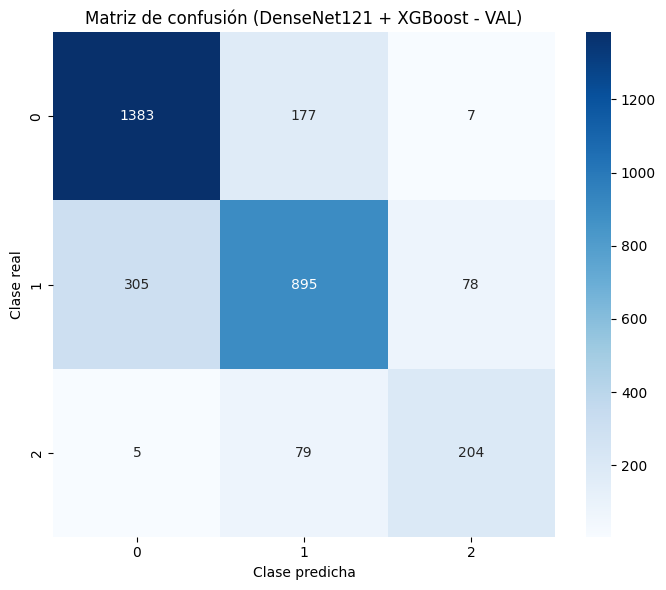

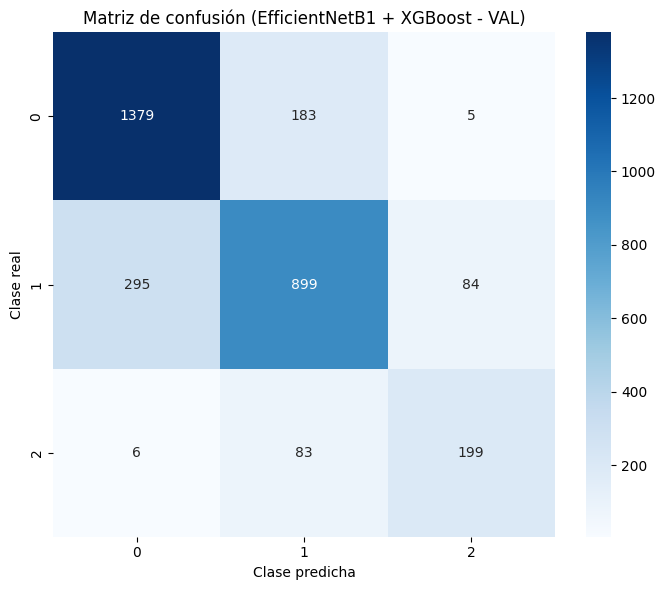

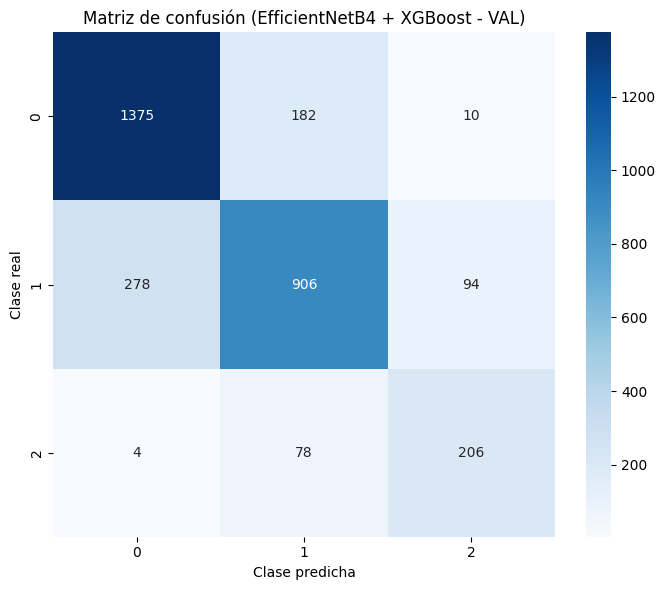

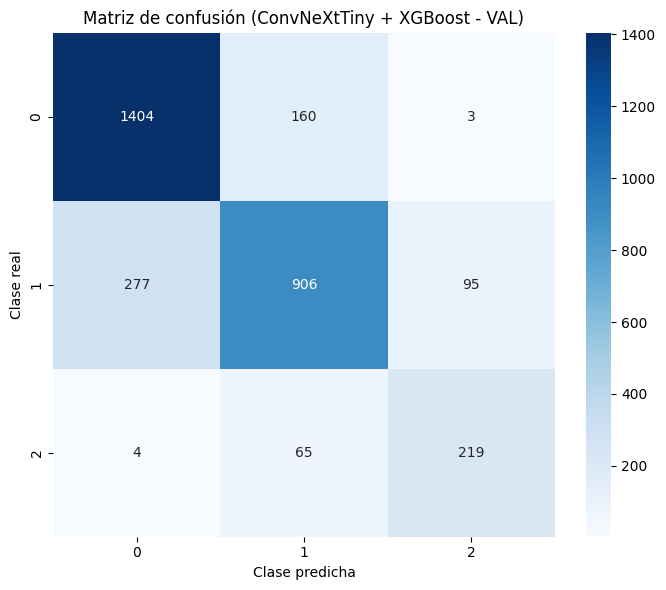

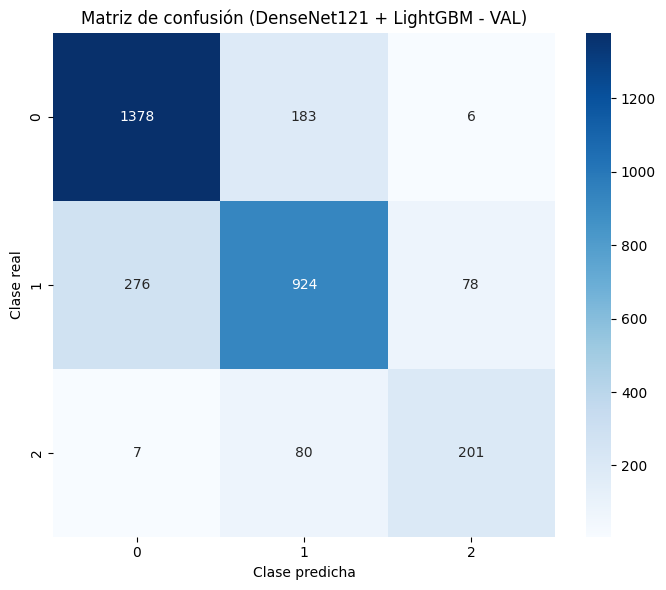

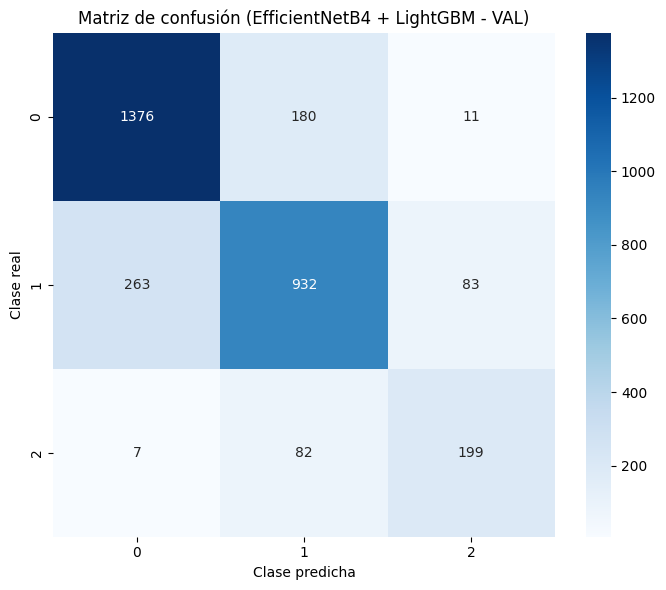

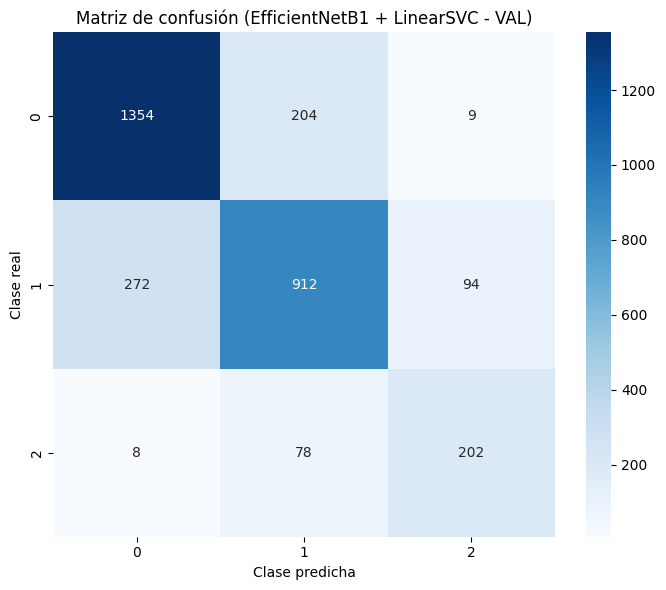

In [28]:
# Matrices de confusión de validación para los 7 candidatos consolidados.
for candidate_name, res in all_candidate_results.items():
    exp_name = str(res["experiment"])
    y_val_local = np.asarray(feature_sets[exp_name]["y_val"])
    y_pred_local = np.asarray(res["y_val_pred"])

    labels_sorted = sorted(int(x) for x in np.unique(y_val_local))
    cm = confusion_matrix(y_val_local, y_pred_local, labels=labels_sorted)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels_sorted,
        yticklabels=labels_sorted,
    )
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.title(f"Matriz de confusión ({candidate_name} - VAL)")
    plt.tight_layout()
    plt.show()

### Importancia de características

Para cada candidato visualizamos las 20 features más importantes según el criterio nativo de cada algoritmo. En XGBoost y LightGBM se usa la ganancia (_gain_), que mide cuánto contribuye cada feature a reducir la función de pérdida en los splits. En LinearSVC se usa la magnitud media de los coeficientes por feature, promediando sobre las clases.

Una limitación importante, las features son dimensiones de un embedding de red neuronal, no variables interpretables directamente (como "presencia de microaneurismas"). La importancia muestra qué dimensiones del vector son más discriminativas, pero no qué patrón visual representan. Para eso se necesitarían técnicas como Grad-CAM o SHAP sobre el backbone.

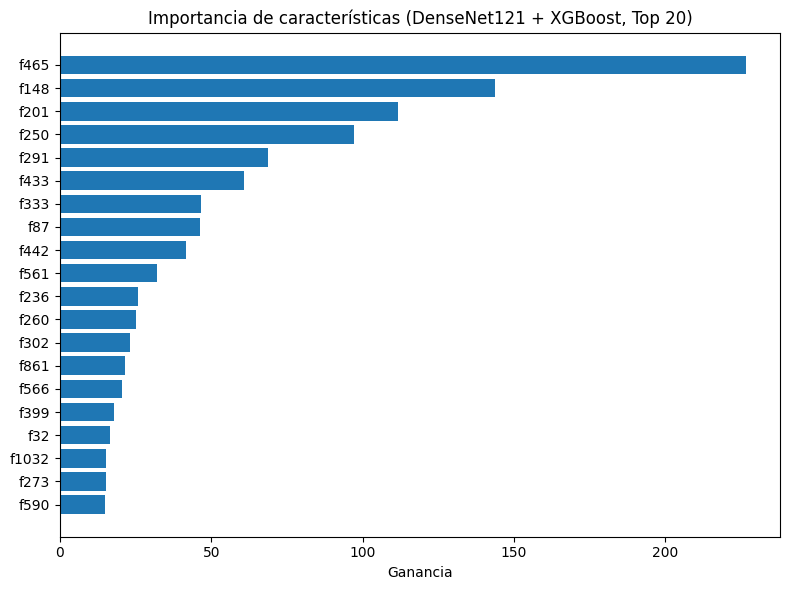

Top características por ganancia (DenseNet121 + XGBoost):


,feature,gain
0,f465,226.513397
1,f148,143.568314
2,f201,111.739937
3,f250,97.103973
4,f291,68.731155
5,f433,60.715206
6,f333,46.661766
7,f87,46.308243
8,f442,41.759533
9,f561,32.125053


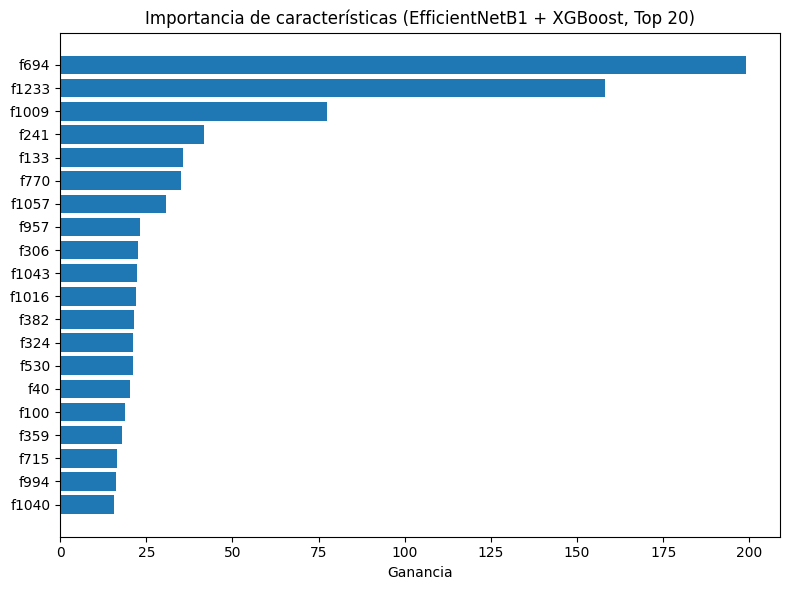

Top características por ganancia (EfficientNetB1 + XGBoost):


,feature,gain
0,f694,198.944031
1,f1233,158.144531
2,f1009,77.316650
3,f241,41.829010
4,f133,35.767712
5,f770,34.979343
6,f1057,30.821402
7,f957,23.133003
8,f306,22.649168
9,f1043,22.249266


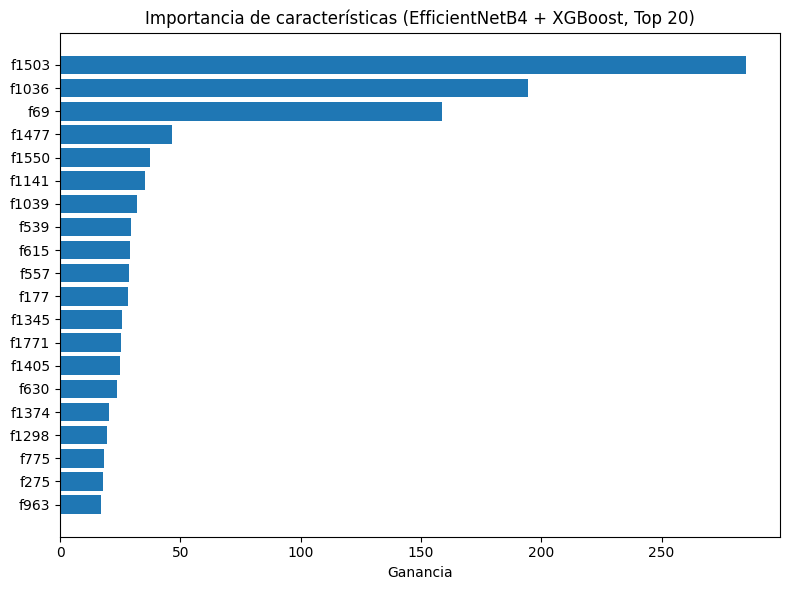

Top características por ganancia (EfficientNetB4 + XGBoost):


,feature,gain
0,f1503,284.995850
1,f1036,194.300354
2,f69,158.825607
3,f1477,46.491821
4,f1550,37.247150
5,f1141,35.223942
6,f1039,31.994957
7,f539,29.610285
8,f615,28.997364
9,f557,28.444780


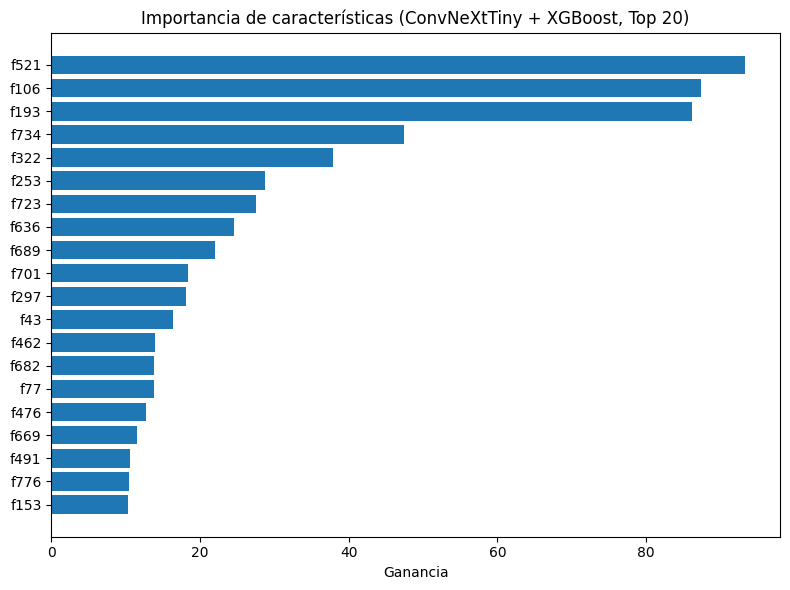

Top características por ganancia (ConvNeXtTiny + XGBoost):


,feature,gain
0,f521,93.363152
1,f106,87.451981
2,f193,86.171249
3,f734,47.506577
4,f322,37.930576
5,f253,28.804901
6,f723,27.489710
7,f636,24.512562
8,f689,21.974253
9,f701,18.448229


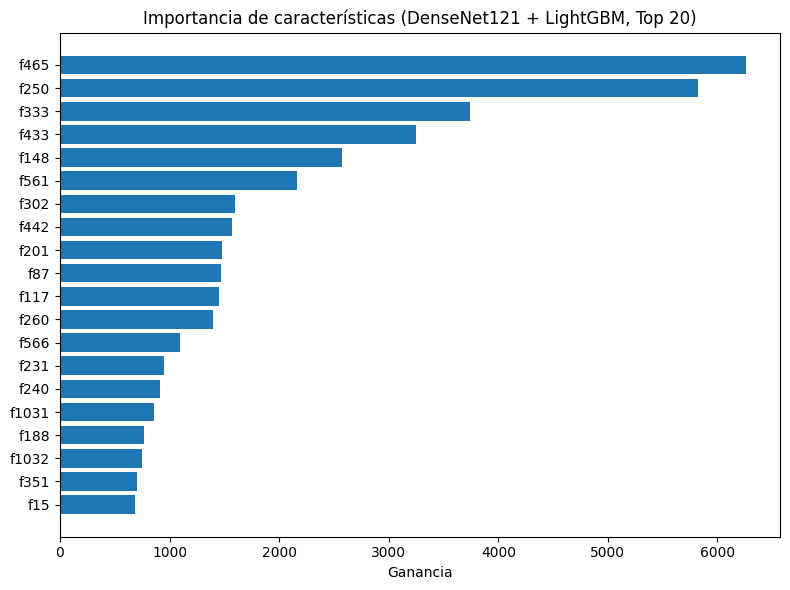

Top características por ganancia (DenseNet121 + LightGBM):


,feature,gain
0,f465,6257.589384
1,f250,5821.668243
2,f333,3741.089360
3,f433,3247.823633
4,f148,2576.956844
5,f561,2160.731983
6,f302,1594.899666
7,f442,1568.474226
8,f201,1478.131938
9,f87,1466.629390


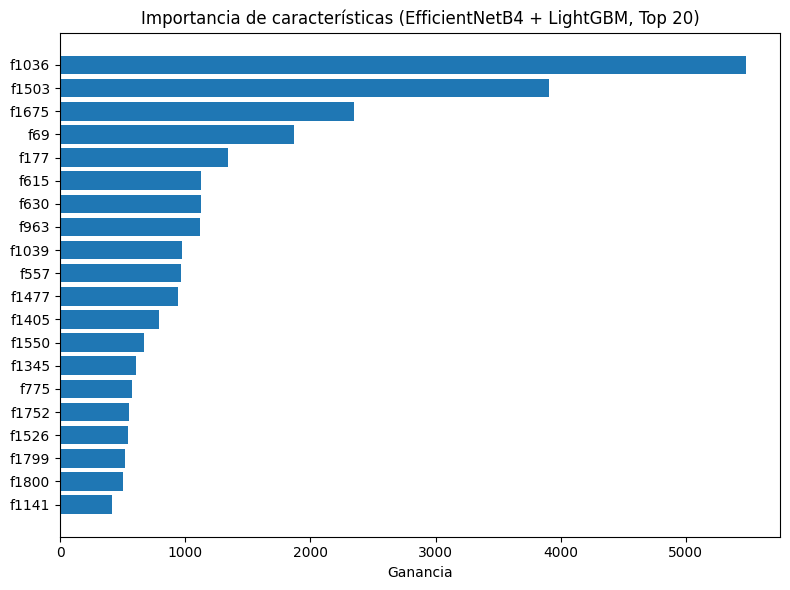

Top características por ganancia (EfficientNetB4 + LightGBM):


,feature,gain
0,f1036,5478.515230
1,f1503,3905.301515
2,f1675,2348.373724
3,f69,1870.912599
4,f177,1341.948311
5,f615,1126.126301
6,f630,1123.118112
7,f963,1119.307834
8,f1039,971.021179
9,f557,963.967400


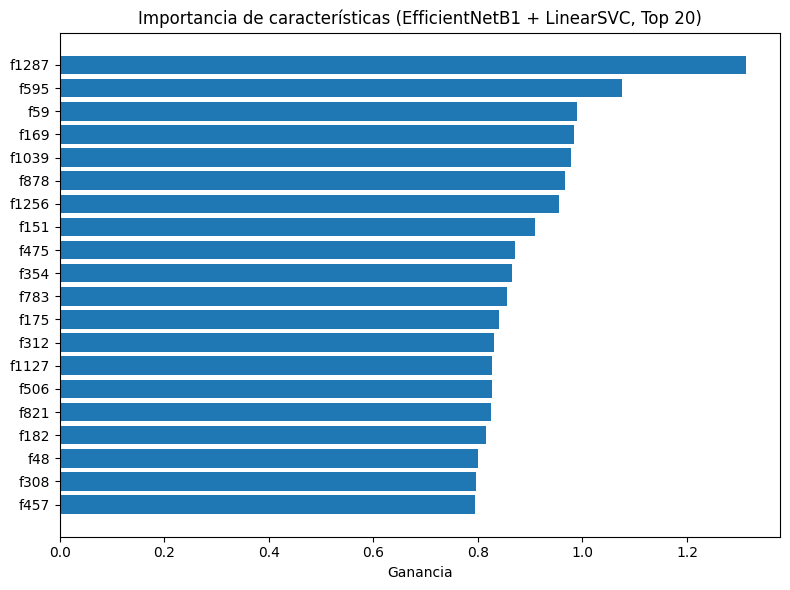

Top características por ganancia (EfficientNetB1 + LinearSVC):


,feature,gain
0,f1287,1.312394
1,f595,1.075134
2,f59,0.989381
3,f169,0.983423
4,f1039,0.978709
5,f878,0.966506
6,f1256,0.954741
7,f151,0.909850
8,f475,0.870997
9,f354,0.864663


In [29]:
# Importancia de características para cada candidato (gain/coeficientes según algoritmo).
for candidate_name, res in all_candidate_results.items():
    model = res["best_model"]
    algo = str(res["algorithm"])

    if algo == "XGBoost":
        score = model.get_booster().get_score(importance_type="gain")
        importance_df = pd.DataFrame(
            {
                "feature": list(score.keys()),
                "gain": list(score.values()),
            }
        )
    elif algo == "LightGBM":
        gain = model.booster_.feature_importance(importance_type="gain")
        importance_df = pd.DataFrame(
            {
                "feature": [f"f{i}" for i in range(len(gain))],
                "gain": gain,
            }
        )
    elif algo == "LinearSVC":
        coef = np.asarray(model.coef_)
        if coef.ndim == 1:
            coef = coef.reshape(1, -1)
        gain = np.mean(np.abs(coef), axis=0)
        importance_df = pd.DataFrame(
            {
                "feature": [f"f{i}" for i in range(len(gain))],
                "gain": gain,
            }
        )
    else:
        raise ValueError(f"Algoritmo no soportado para importancia: {algo}")

    importance_df = (
        importance_df.sort_values("gain", ascending=False)
        .reset_index(drop=True)
    )

    top_k = 20
    top_df = importance_df.head(top_k)

    plt.figure(figsize=(8, 6))
    plt.barh(top_df["feature"][::-1], top_df["gain"][::-1])
    plt.xlabel("Ganancia")
    plt.title(f"Importancia de características ({candidate_name}, Top {top_k})")
    plt.tight_layout()
    plt.show()

    print(f"Top características por ganancia ({candidate_name}):")
    display(top_df)

### Nota de cierre

Con esto el notebook compara explícitamente 7 combinaciones: DenseNet121, EfficientNetB1, EfficientNetB4 y ConvNeXtTiny con XGBoost, más DenseNet121 y EfficientNetB4 con LightGBM, y EfficientNetB1 con LinearSVC. La selección de `final_model` queda determinada por el mejor macro-F1 en validación entre las siete opciones.

## Conclusiones

En este trabajo evaluamos 7 combinaciones de backbone (extractor de características) + modelo tabular para clasificar retinopatía diabética en 3 niveles de severidad, a partir del esquema de 5 a 3, y tomamos la decisión final usando el macro-F1 en validación como métrica principal.

Lo más importante es que todos los candidatos superaron el baseline ingenuo, lo cual refuerza una idea clave de que los embeddings preentrenados sí están capturando señal útil para este problema. También vimos que el backbone realmente importa. En general, modelos con más capacidad como *EfficientNet-B4* tienden a producir *features* más discriminativas, pero a cambio exigen mayor costo de extracción. En contraste, alternativas más ligeras como *DenseNet-121* y *ConvNeXt-Tiny* ofrecen un balance muy razonable entre rendimiento y velocidad, lo cual es especialmente útil cuando se está iterando rápido y afinando el pipeline.

En términos de resultados, el mejor candidato por macro-F1 de validación fue **ConvNeXtTiny + XGBoost**, con `val_f1_macro=0.779872` y `val_accuracy=0.807214` (además de `val_precision_macro=0.775049` y `val_recall_macro=0.788439`). Algo interesante es que, a pesar de ser un backbone relativamente ligero, también fue el más eficiente en tiempo dentro de los modelos basados en XGBoost, con `total_search_time_sec=62.43`, lo que lo convierte en una opción muy atractiva cuando buscamos un buen equilibrio entre rendimiento y costo computacional.

Otro punto que nos ayudó bastante fue la fusión de clases. En la práctica, este ajuste redujo confusión entre severidades cercanas y volvió el entrenamiento más estable, sin perder el objetivo del análisis, distinguir entre “sin DR”, “DR leve/moderada” y “DR severa/proliferativa”, que es un esquema más robusto para esta etapa del proyecto.

Del lado de los modelos tabulares, notamos matices interesantes. LightGBM con `class_weight="balanced"` suele aprovechar mejor el desbalance residual y se comporta de manera muy consistente. LinearSVC también resultó competitivo, lo cual sugiere que, cuando los embeddings ya separan bien el problema, un clasificador lineal puede ser una opción sorprendentemente fuerte. En términos prácticos, con un backbone ligero como DenseNet-121 se puede prototipar y experimentar rápido; y con EfficientNet-B4 se puede ir cuando el objetivo es exprimir el máximo rendimiento y el costo de extracción no es una limitación.

Además de estos candidatos, también intentamos explorar un par de enfoques puramente basados en redes neuronales convolucionales con salidas de capas densas. Sin embargo, por el tiempo disponible no fue posible hacer una búsqueda de hiperparámetros lo suficientemente cuidadosa como para compararlas de forma justa. Los resultados preliminares, con hiperparámetros elegidos “a ojo”, quedaron por debajo de la mayoría de los candidatos presentados aquí, y además complicaban bastante la estructura y el mantenimiento de este notebook. Por eso decidimos dejarlas fuera por ahora. Aun así, planeamos seguir trabajando con esas variantes durante esta semana y, si logramos mejoras reales, podríamos incorporarlas como experimentos adicionales en la siguiente entrega.

Finalmente, vale la pena mencionar que las combinaciones que probamos aquí no fueron elegidas al azar, varias están inspiradas en propuestas que revisamos en los papers consultados, donde es común usar backbones preentrenados como extractores y después entrenar un modelo como **XGBoost** o **LightGBM** sobre los embeddings. También tomamos como referencia trabajos que reportan buenos resultados usando ciertos backbones para extraer características en datasets de retinopatía diabética. Dado el tiempo acotado, enfocarnos en este enfoque híbrido (embeddings + modelo tabular) fue una manera efectiva de explorar un espacio amplio de candidatos con resultados sólidos. Como trabajo futuro, nos gustaría dedicar más tiempo a explorar arquitecturas neuronales más complejas y estrategias de entrenamiento end-to-end, ya con una búsqueda de hiperparámetros adecuada.

Con todo lo anterior, el modelo final seleccionado es el que obtuvo el **mayor macro-F1 en validación** entre los 7 candidatos evaluados.

## Limitaciones y siguientes pasos

El merge de 5 a 3 reduce granularidad: no podemos distinguir entre leve (1) y moderada (2), ni entre severa (3) y proliferativa (4), lo que limita la utilidad clínica directa. La búsqueda de hiperparámetros está acotada (`n_iter=12`, `cv=3`), así que es posible que haya configuraciones mejores sin evaluar. Los resultados dependen de un único split train/val 75/25, sin conjunto de test independiente en este notebook. Los backbones se usan como extractores fijos (sin fine-tuning), y las features son dimensiones opacas de embeddings sin interpretabilidad directa.

A partir de aquí los pasos naturales serían, evaluar el modelo final en un conjunto de test no visto, calibrar probabilidades para poder tomar decisiones con umbrales de riesgo, analizar cualitativamente los errores (sobre todo falsos negativos en clase 2), explorar estrategias de desbalance más finas como SMOTE o focal loss, ajustar umbrales orientados a riesgo priorizando sensibilidad en clases severas, descongelar las últimas capas del backbone para fine-tuning con datos de retinopatía, y usar validación cruzada completa (k-fold) para obtener intervalos de confianza en las métricas.

Referencias:

- *Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700-4708).*
- *Kumar, V., Sharma, G., & Garg, D. (2023, November). Analysis of Early Detection and Prediction of Diabetic Retinopathy by Optimize Deep Learning with XG-Boosting. In Conference on Smart Generation Computing and Communication Networks (pp. 61-69). Cham: Springer Nature Switzerland.*
- *Nahiduzzaman, M., Islam, M. R., Goni, M. O. F., Anower, M. S., Ahsan, M., Haider, J., & Kowalski, M. (2023). Diabetic retinopathy identification using parallel convolutional neural network based feature extractor and ELM classifier. Expert Systems with Applications, 217, 119557.*
- *Nneji, G. U., Cai, J., Deng, J., Monday, H. N., Hossin, M. A., & Nahar, S. (2022). Identification of diabetic retinopathy using weighted fusion deep learning based on dual-channel fundus scans. Diagnostics, 12(2), 540.*
- *Meenakshi, K., Kishore, D., & Srinivasa Rao, C. (2024, October). Enhanced Detection of Diabetic Retinopathy Through Transfer Learning with DenseNet-121 and XGBoost Classifier. In International Conference on Computer & Communication Technologies (pp. 409-419). Singapore: Springer Nature Singapore.*
- *Visengeriyeva, L., Kammer, A., Bär, I., Kniesz, A., y Plöd, M. (2023). CRISP-ML(Q). The ML Lifecycle Process. MLOps. INNOQ.*